
# Assignment 2 - Nlp21 #

## Amir Bachar, 301768925

## Hillel Lehman, 204006548


## Q1.1 ##


One of the NLP's important task is the Open-domain question answering, say [Xin Li](https://ece.duke.edu/faculty/xin-li) and [Dan Roth](https://www.cis.upenn.edu/~danroth/) in their [article](http://www.aclweb.org/anthology/C02-1150). It's more complicated then a common search – we need not only to find  relevant document, but to decide on one clear answer – and doing so when sometimes the question and the answer uses different terms to describe the same entities.

An important stage of this process is recognizing the wanted **"type"** of an answer. Are we looking for a `name`? are we interested in a `description`? Determining the type is a key rule in bringing the desired answer. So, our first step is not answering the question nor search for relevant information but classify the answer type we are looking for.
The precise type will help us to locate and verify our answer, and more important – will lead us to the right strategy to solve this task. More classes will make our search easier, but there is a limit to the number of classes we can take in consideration, and today's system usually classify question to no more than 20 classes.

A good starting point might be using rules that determine the type of question-based on the question word. For example, questions that begin with who or whom will probably looking for a person answer-type. But this kind of rules require us to analyze the semantics and syntactic rule of the different token of the question and is also less likely to succeed with questions which their pattern is less classic. 

We will use 6 coarse classes we will discuss soon, and 50 fine classes, each is a sub-category of the 6 main classes.  
Let's examine some example of our six classes:

**`ABBREVIATION`**
English uses a lot of abbreviations, and we would like to represent both directions – `abb` for an answer which is an abbreviation, and an answer which is an expression represented by abbreviation – these will be classified as `exp`.
Let see some examples:

*What does NASDAQ stand for?*
This is an `exp` – we are looking for the expression "National Association of Securities Dealers Automated Quotations".
The other way around is a question like
*What is the abbreviation of the company name  General Motors?*. Here we would like to receive an answer of type `abb` – GM.

**ENTITY**
As its name suggests, these class holds many fine-classes of different entities. It is one of the biggest class, and many times the answer might fit several fine classes of entities, due to close definitions of entities. Here are some examples:

*What creature scares people in the film 'Jaws'?* – a clear answer will be a shark, and when looking for a class, we will call it `animal`. Of course, we could have found even finer class like an "aquatic animal", but as we said, too fine is too much here.

*Where does your hair grow the fastest?*  is looking for a `body` type. Other fine-classes are `product`, `vehicle`, `event`, and many more. Of course, we can't cover everything, so we have `other` as well, for undefined entities.

**DESCRIPTION**
This class has four fine-classes: `definition`, `description`, `manner` and `reason`.

*What is a firewall?* Is looking, of course, for `definition`, while *Why is the grass green*
should be categorized `reason`. 

**HUMAN**
An important class, holds `group`, `ind` (individual), `title`, and `description` as fine-classes. Many times few types represent the same entity – "Bibi", "Benjamin Netanyahu", "ROHAM", and "The prime minister of Israel" are all refer to one person (at least until the coming election…).
It demonstrates the challenge of question answering comparing to searching – a good **searching result** to all these terms might be a link to his Wikipedia page, but the **answers** to *What ROHAM stands for* and *who is known as Bibi* are completely different. 


**LOCATION**
Many times we will look for locations. From Trivia questions to the destination for the next summer vacation abroad (we are optimistic…) – locations are what we look for.
It has five fine-classes: `city`, `country`, `mountain`, `state` and of course the unavoidable `other`.
An interesting question might be *What U.S. state lived under six flags*
Which looks for a `state` type (the answer, by the way, is **Texas**! more about that [can be found here](https://en.wikipedia.org/wiki/Six_flags_over_Texas)), but many time we will meet the `other` category:
*What sea did the Romans call mare nostrum?*


**NUMERIC VALUE**
`Codes`, `count`, `dates`, `temp`, `size`, `weight`… Numbers are an important part of our daily life and many time that is the class we are looking for. There are dozens of optional category, but in this case, we chose 13 fine-classes, included `other`.
Of course, this class is the **most important one!** After all, it holds the answer to **the most important question**: *what is the meaning of life?*…






# Q1.2. Dataset Reader #

Let's start by read our Data and parse it so it fits our needs.
We will split it to lines of `\[ < coarse category > , < fine category >, [< the question splited to words >] \]`, which will help us to use it easily later. 
As a beginning, we will build a dictionary of { < coarse category > , \[< list of its fine categories \]:

In [169]:
import codecs
import glob
import math
import random
import string
import time
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

def findFiles(path): return glob.glob(path)


def parseLine(line):
    coars_rest = line.split(":")
    coars_fine_question = [coars_rest[0]]+coars_rest[1].split(" ", 1)
    coars_fine_question[2] = coars_fine_question[2][:-2].split(" ")
    return coars_fine_question  # returns the pattern ['DESC', 'def', ['What', 'is', 'pectin']]


def readLines(filename):
    lines = codecs.open(filename, "r", encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [parseLine(line) for line in lines]


lines = []
for filename in findFiles('../data/train_5500.label.txt'):
    lines += readLines(filename)
    
coarse_categories = ["ABBR", "ENTY", "DESC", "HUM", "LOC", "NUM"]
fine_categories = {category:list() for category in coarse_categories}
for line in lines:
    if not line[1] in fine_categories.get(line[0]):
        fine_categories[line[0]].append(line[1])

print("Our data is now looks like this:")
print(lines[random.randint(0, len(lines))])

Our data is now looks like this:
['NUM', 'dist', ['How', 'deep', 'is', 'a', 'fathom']]


Let's use Pandas to see what we got (we use `display` instead of `print` to get the pretty table):

In [170]:
i = 0
for cat in fine_categories.values():
    i += len(cat)
print("Number of fine-category in our data set:", i)

fc = pd.DataFrame.from_dict(fine_categories, orient='index', dtype=None, columns=None)

with pd.option_context('display.max_columns', None):
    fc.fillna("", inplace=True)
    fc.describe()
    display(fc)


num_of_fines = []
num_of_coarses = []
num_of_token_per_question = 0
num_of_token_per_fine_label = {}
num_of_token_per_coarse_label = {category:0 for category in coarse_categories}
vocabulary_overall = []
vocabulary_per_fine_label = {}
vocabulary_per_coarse_label = {category:[] for category in coarse_categories}
for categories in fine_categories:
    for category in fine_categories[categories]:
        num_of_token_per_fine_label[category] = 0
        vocabulary_per_fine_label[category] = []

for line in lines:
    num_of_coarses.append(line[0])
    num_of_fines.append(line[1])
    num_of_token_per_question+=(len(line[2]))
    num_of_token_per_fine_label[line[1]]+=len(line[2])
    num_of_token_per_coarse_label[line[0]]+=len(line[2])
    for word in line[2]:
        if word.islower():  # make sure we dont take things like "" or '
            vocabulary_overall += [word]
            vocabulary_per_fine_label[line[1]].append(word.strip('.,'))
            vocabulary_per_coarse_label[line[0]].append(word.strip('.,'))
count_vocabulary_per_fine_label = {}
for category in vocabulary_per_fine_label:
    temp = {category:len(set(vocabulary_per_fine_label[category]))}
    count_vocabulary_per_fine_label.update(temp)


Number of fine-category in our data set: 50


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
ABBR,exp,abb,,,,,,,,,,,,,,,,,,,,
ENTY,cremat,animal,event,other,letter,religion,food,color,termeq,body,dismed,product,substance,sport,plant,techmeth,instru,word,lang,symbol,veh,currency
DESC,manner,def,reason,desc,,,,,,,,,,,,,,,,,,
HUM,ind,gr,title,desc,,,,,,,,,,,,,,,,,,
LOC,state,other,country,city,mount,,,,,,,,,,,,,,,,,
NUM,date,count,money,period,volsize,other,speed,perc,code,dist,temp,ord,weight,,,,,,,,,


As always, before we process our dataset we would like to **understand** it. Let's do so by examine some statistics about the different categories.

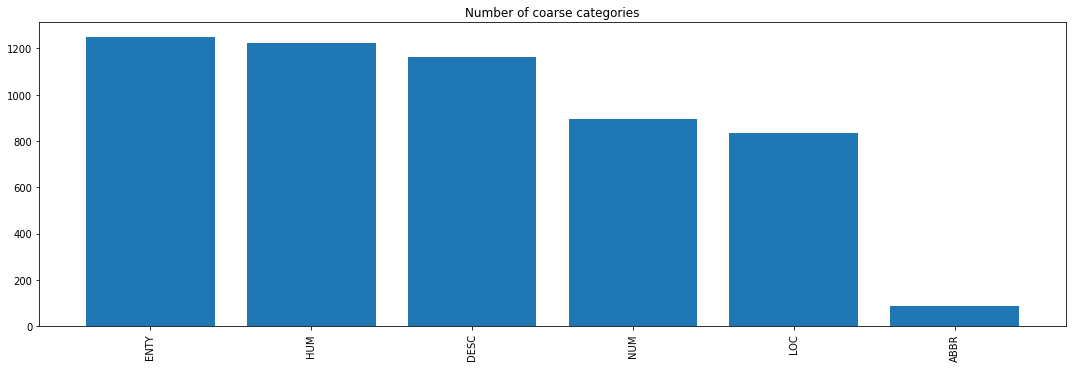

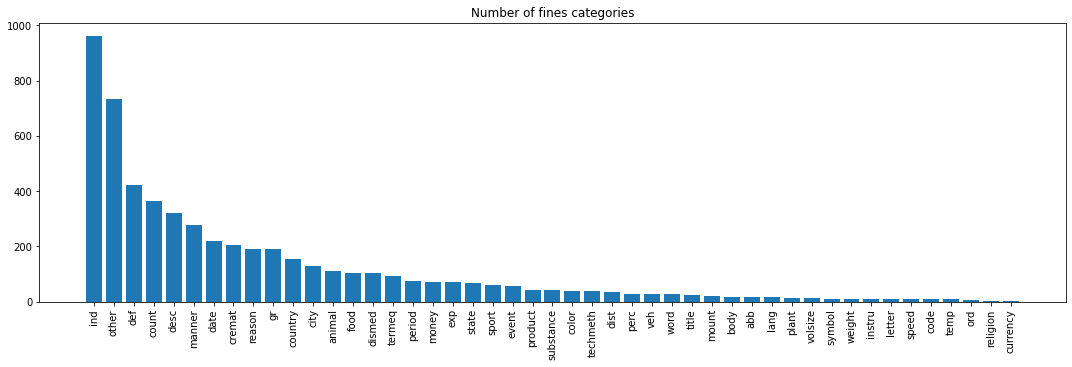

In [171]:
num_of_coarses = Counter(num_of_coarses).most_common(6)  # using most_common to get tuples

from termcolor import colored
coarse, frequency = zip(*num_of_coarses)
indices = np.arange(len(num_of_coarses))
plt.bar(indices, frequency)
plt.xticks(indices, coarse, rotation='vertical')
plt.tight_layout()
plt.title("Number of coarse categories")
plt.show()

# distribution of coarse-categories
num_of_fines = Counter(num_of_fines).most_common(50)
fine, frequency = zip(*num_of_fines)
indices = np.arange(len(num_of_fines))

plt.bar(indices, frequency)
plt.xticks(indices, fine, rotation='vertical')
plt.tight_layout()
plt.title("Number of fines categories")
plt.show()


<a name="q1.3"></a>
<h3>Q1.3. Dataset Exploration</h3>


Allright, so we have some basic knowledge - let's expend it!
We would like to know some more intersting fucts about our dataset. How long our the questions? How big is the vocabulary we are dealing with?
Well, let's find out!

Number of tokens per question: 9.1 



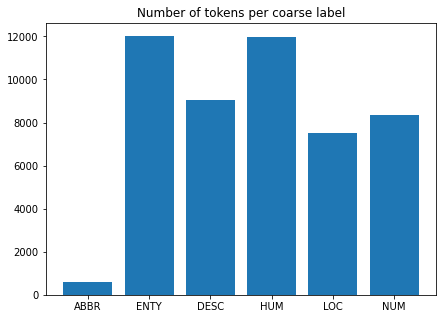

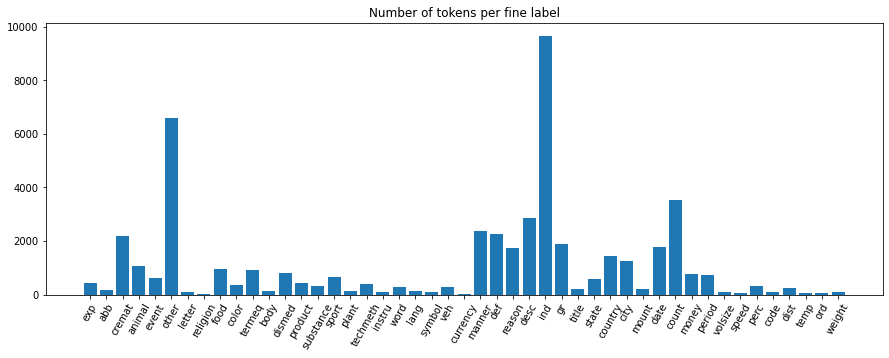

Vocabulary size overall: 5602
Vocabulary size per coarse label:
ABBR : 83
ENTY : 2310
DESC : 1918
HUM : 1838
LOC : 1150
NUM : 1407


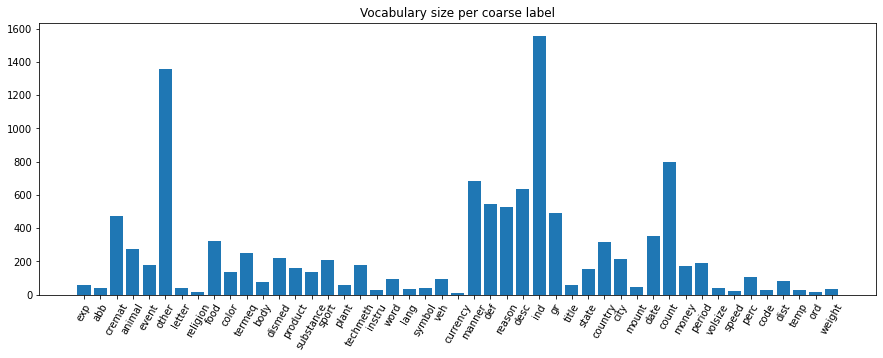

*Top 20 most frequent words ovel all*
Lets first see the most frequent word together with the number of words overall,
 and number of unique words. No surprises here:
            0
count   34345
unique   5602
top       the
freq     3588
The overall 20 most-frequent words:


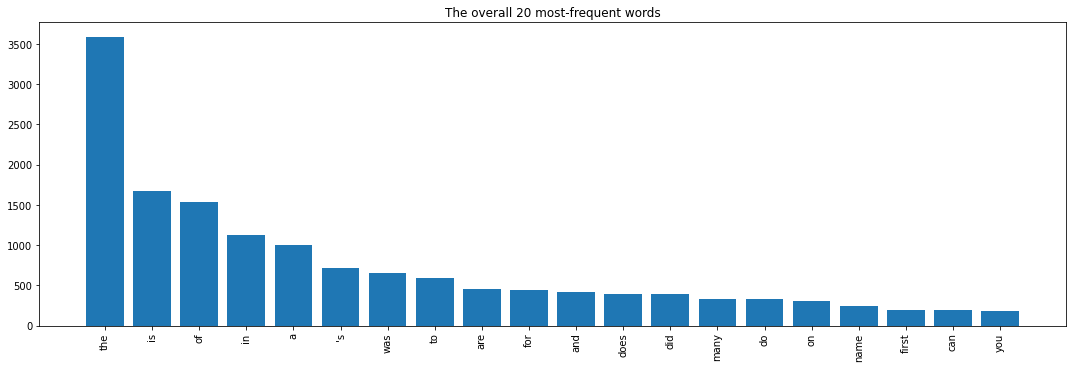

The coarse categories 20 most-frequent words:


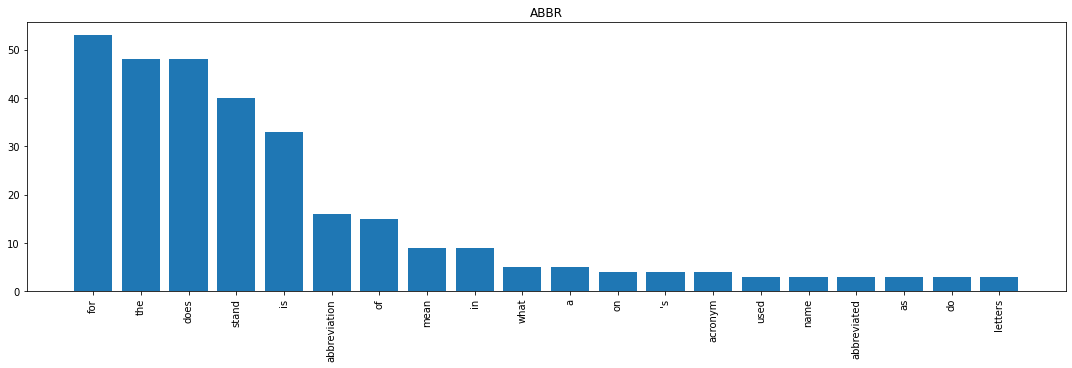

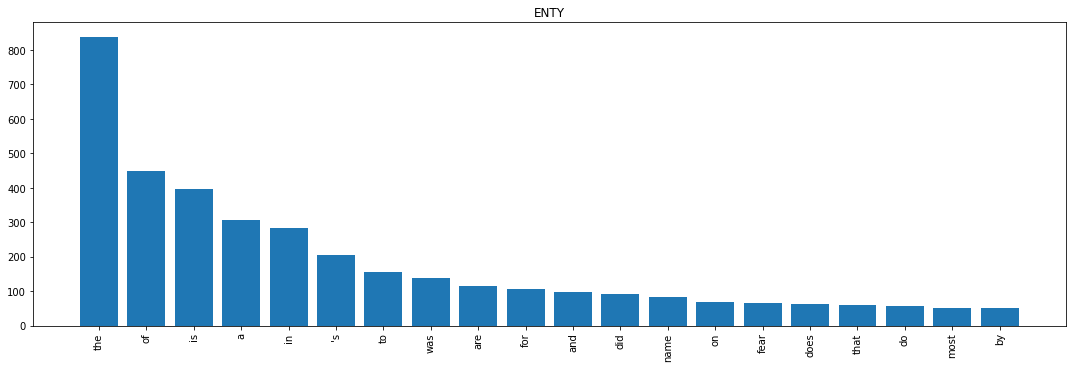

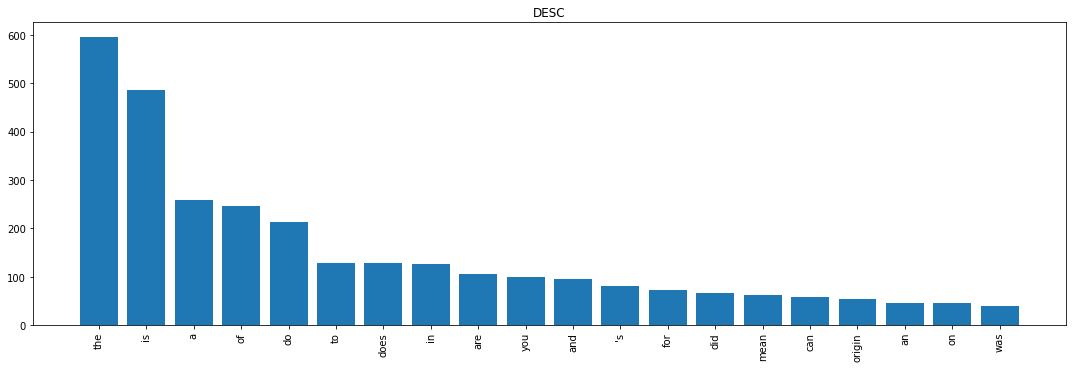

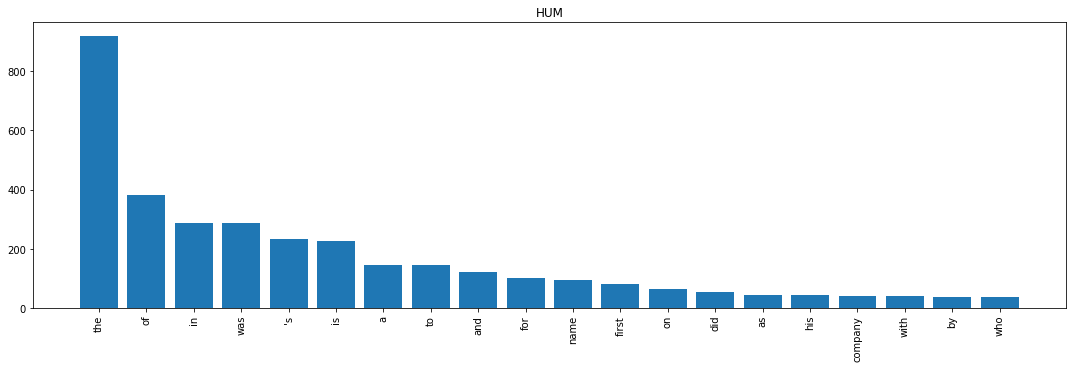

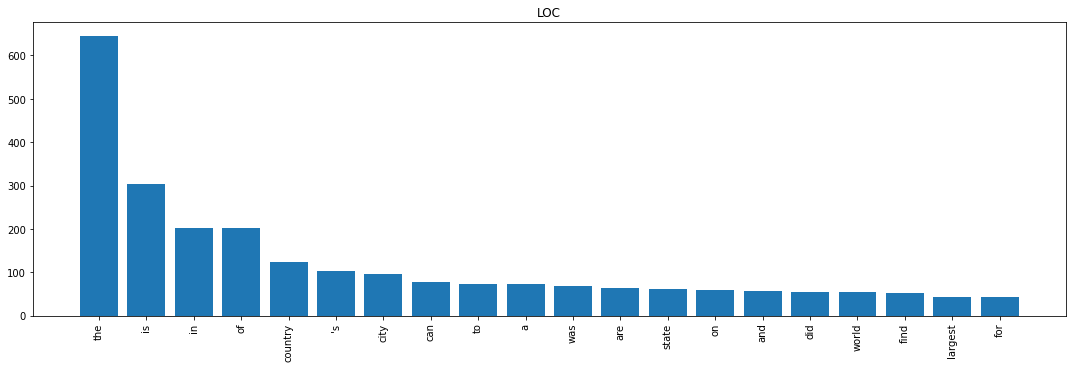

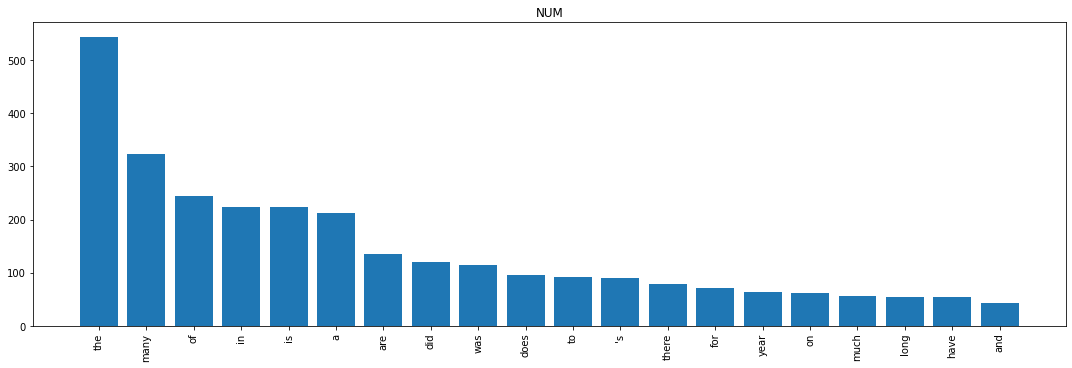

Number of words ocuuring 1 times: 3305 - which is  59.0 % of the words
Number of words ocuuring 2 times: 872 - which is  15.6 % of the words
Number of words ocuuring 3 times: 387 - which is  6.9 % of the words
Number of words ocuuring 4 times: 226 - which is  4.0 % of the words
Number of words ocuuring 5 times: 148 - which is  2.6 % of the words


In [172]:
print(colored("Number of tokens per question:",attrs=['bold']), round(num_of_token_per_question/len(lines),1),"\n" )

labels, values = zip(*num_of_token_per_coarse_label.items())
plt.rcParams['figure.figsize'] = [7,5]
plt.bar(labels, values)
plt.title("Number of tokens per coarse label")
plt.show()


labels, values = zip(*num_of_token_per_fine_label.items())
plt.rcParams['figure.figsize'] = [15,5]
plt.bar(labels, values)
plt.xticks(rotation=60)
plt.title("Number of tokens per fine label")
plt.show()

print(colored("Vocabulary size overall:",attrs=['bold']), len(set(vocabulary_overall)))

print(colored("Vocabulary size per coarse label:",attrs=['bold']))
for label in vocabulary_per_coarse_label:
    print(label,":", len(set(vocabulary_per_coarse_label[label])))
    

labels, values = zip(*count_vocabulary_per_fine_label.items())
plt.bar(labels, values)
plt.xticks(rotation=60)
plt.title("Vocabulary size per coarse label")
plt.show()
    
print(colored("*Top 20 most frequent words ovel all*",attrs=['bold']))
print("Lets first see the most frequent word together with the number of words overall,\n\
 and number of unique words. No surprises here:")
freq_overall = pd.DataFrame(vocabulary_overall)
print(freq_overall.describe())

print(colored("The overall 20 most-frequent words:",attrs=['bold']))
most_common_vocabulary_overall = Counter(vocabulary_overall).most_common(20)
word, frequency = zip(*most_common_vocabulary_overall)
indices = np.arange(len(most_common_vocabulary_overall))
plt.bar(indices, frequency)
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.title("The overall 20 most-frequent words")
plt.show()

print(colored("The coarse categories 20 most-frequent words:",attrs=['bold']))
for category in coarse_categories:
    curr_label = Counter(vocabulary_per_coarse_label[category]).most_common(20)
    word, frequency = zip(*curr_label)
    indices = np.arange(len(curr_label))
    plt.bar(indices, frequency)
    plt.xticks(indices, word, rotation='vertical')
    plt.tight_layout()
    plt.title(category)
    plt.show()
counter_vocabulary_overall = Counter(vocabulary_overall)
occurs = Counter(counter_vocabulary_overall.values())
for i in range(1,6):
    print("Number of words ocuuring",i,"times:" ,occurs[i], "- which is ", round((occurs[i]/len(set(vocabulary_overall)))*100,1),"% of the words")


As expected, the word 'the' lead almost every category, but it does seem like there are some key words in every class - this data will be soon very helpful.

<a name="q1.4"></a>
<h3>Q1.4. Classifier Interface, Evaluation Metrics, Confusion Matrix</h3>

Define the Python interface (functions or class according to your preference) of a question classifier so that the 
function accuracy_score and classification_report from the sklearn.metrics module can be used.

Define a function evaluate_classifier that takes a trained classifier and reports classification results for 
coarse and fine categories.

Define a function confusion_matrix(model) which prints a confusion matrix for the coarse level categories in the same
way as in HW1 Question 3.






In [421]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report as clsf_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

def extract_true(lines):
    Y_coarse, Y_fine = [], []
    for line in lines_to_insert:
        Y_coarse += [(line[0])]
        Y_fine += [(line[1])]
    return Y_coarse, Y_fine


def plot_confusion_matrix(true,predicted,title, annot=True, fmt='.2%'):
    lables =  set(true).union(predicted)
    conf_mat = confusion_matrix(true, predicted)
    norm_conf_mat = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(norm_conf_mat, annot=annot, fmt=fmt,
                xticklabels=lables, yticklabels=lables)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title, pad = 20)
    plt.show()

fine_to_coarse_d = {fine: coarse for coarse, fine_l in fine_categories.items() for fine in fine_l}

def evaluate_classifier(clf, X, y, title, clf_is_fine=False, y_is_fine=False):
    print("It's reporting time!")
    y_pred = clf.predict(X)
    if clf_is_fine and y_is_fine:
        plot_confusion_matrix(y, y_pred, title + ' - Fine', annot=False)
        print(clsf_report(y, y_pred)) 
    if clf_is_fine:
        y_pred = [fine_to_coarse_d[yy] for yy in y_pred]
    if y_is_fine:
        y = [fine_to_coarse_d[yy] for yy in y]
    plot_confusion_matrix(y, y_pred, title + ' - Coarse')
    print(clsf_report(y, y_pred)) 
    
            

<a name="q1.5"></a>
<h3>Q1.5 Baseline Classifier</h3>
Let's try to define some rules that may help us classify our question. We can think of some immidiate idea:
'who', 'whom', and 'whose' are probably indicate question that its answer is `PER`. 'where', we can assume, looking for a `LOC`
and 'when' is probably answered with a `NUM`. It's a goss start, but what about 'why', 'which' 'what' and 'how'?
It seems less clear, so let's run some checks on our data. It is pretty big, so we can assume it inflect some common use:


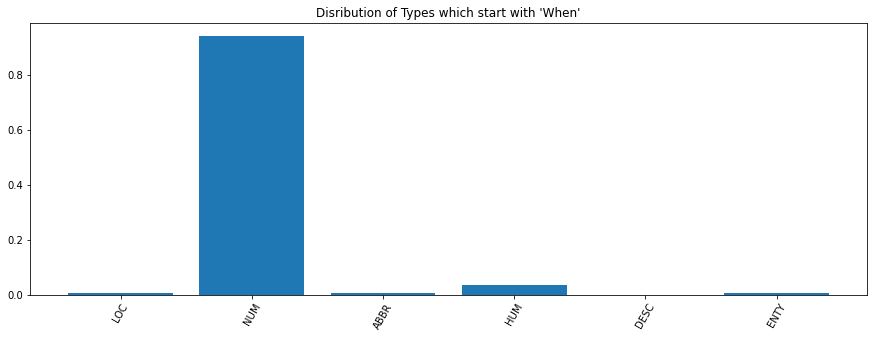

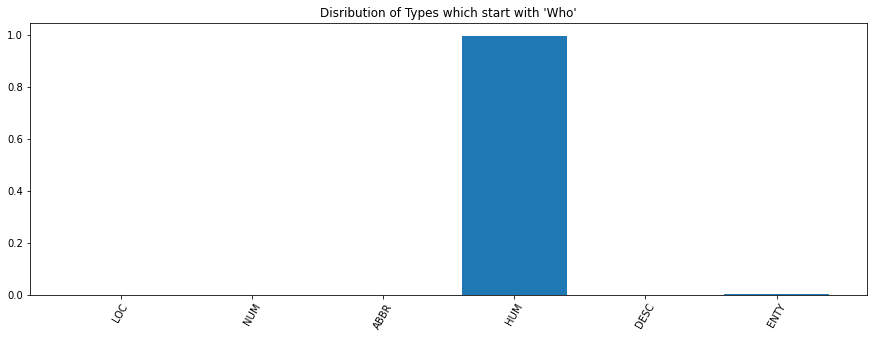

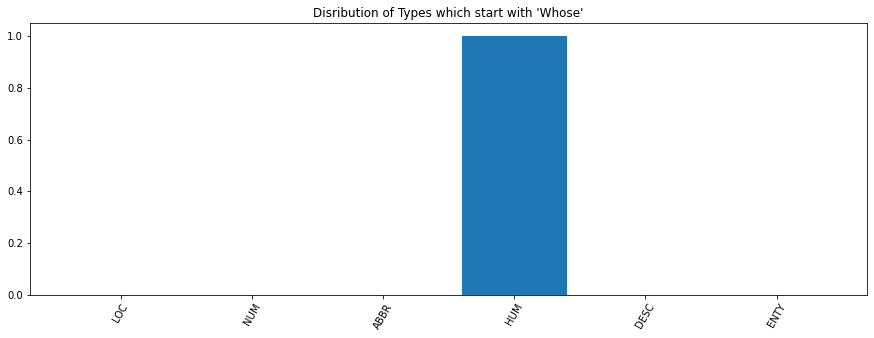

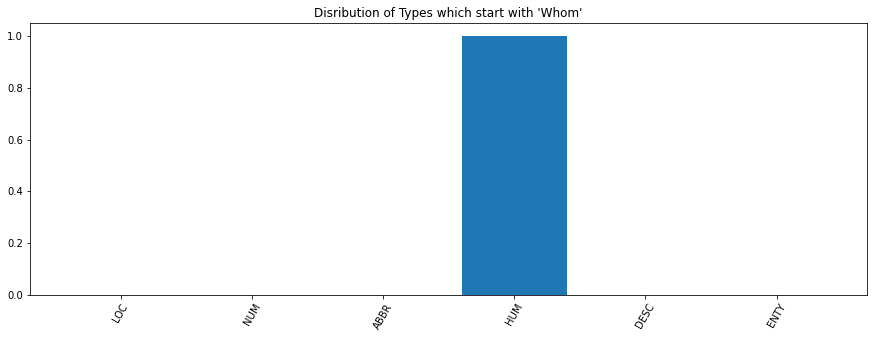

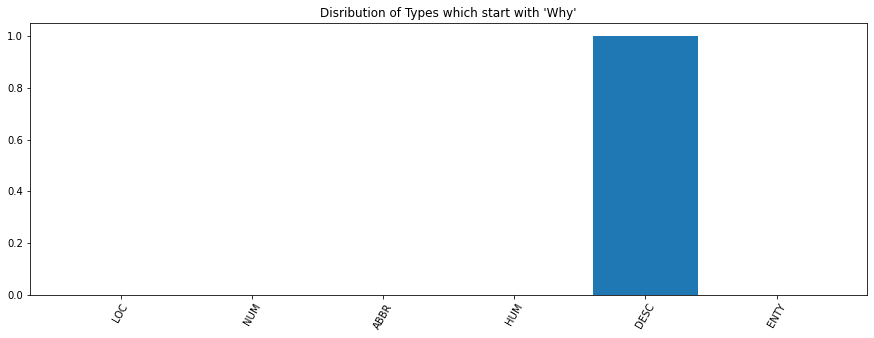

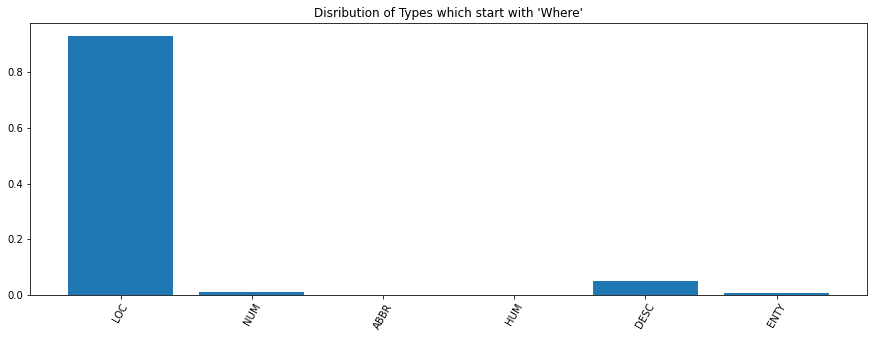

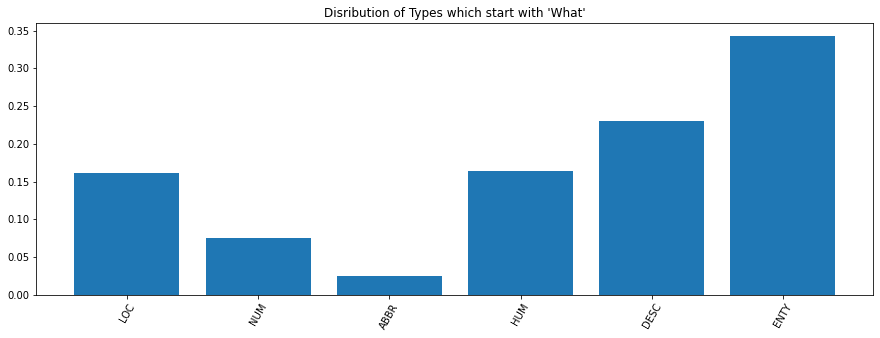

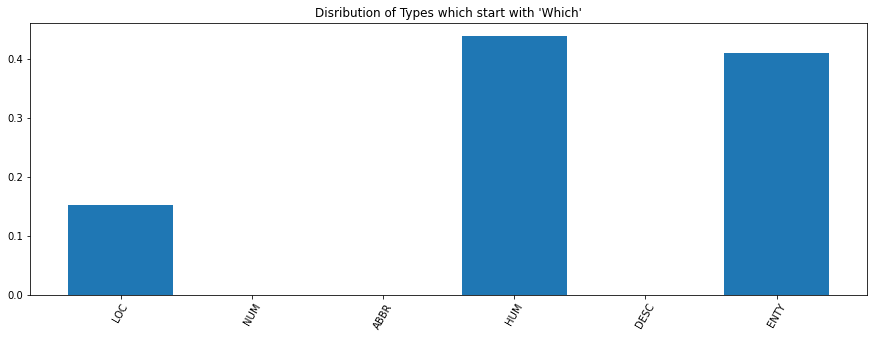

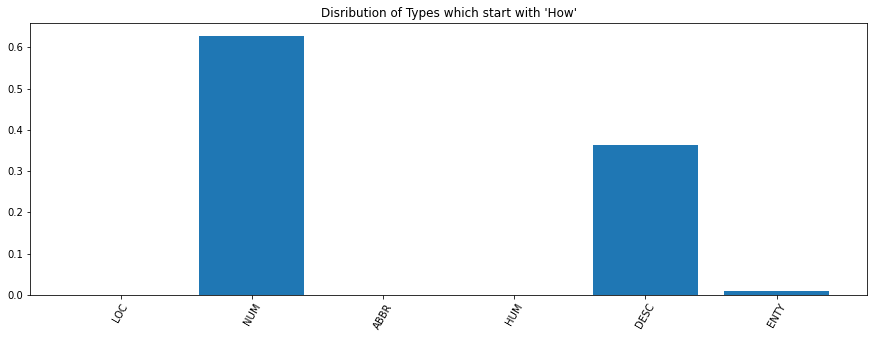

In [330]:
def find_first_word_dist(word):
    word = word.capitalize()
    start_with_what = {"LOC":0, "NUM":0, "ABBR":0, "HUM":0, "DESC":0, "ENTY":0}
    for line in lines:
        if  word in line[2]: start_with_what[line[0]] += 1

    labels, values = zip(*start_with_what.items())
    values = [value/sum(values) for value in values]
    plt.bar(labels, values )
    plt.xticks(rotation=60)
    plt.title("Disribution of Types which start with '"+word+"'")
    plt.show()



for wh in ["when", "who", "whose", "whom", "why", "where", "what", "which","how"]:
    find_first_word_dist(wh)



So as we expected, 'who', 'whom', and 'whose'are unQUESTIONable... So are 'where', and 'when'. 'how' is splitted between `NUM` and `DESC` but we can easily solve it by checking if 'how' is followed by 'old', 'many' or 'long' for `NUM`. But 'which' and 'what' don't have specific
label they tend to belong to. 

Luckily, we check the most common token of every label in previous questions, and this information might be very useful now!
`ENTY` seems to be too general, we will use it as the chose if nothing else was chosen.

In [331]:
import re
def detect_type_by_text(question):
    question_text =  ' '.join([str(word) for word in question])
    first_word = question[0].lower()
    if first_word == "who" or first_word == "whom" : return "HUM"
    if first_word == "where": return "LOC"
    if first_word == "when" or (first_word == "how" and question[1] in ["much","many", "old" "long"]): return "NUM"
    if  bool(re.search(r'abbreviation | stand for | does| acronym | abbreviated', question_text)): return "ABBR"
    if  bool(re.search(r'for how|average | percentage | year | date | number', question_text)): return "NUM"
    if  bool(re.search(r'whose|was | name | first | invented', question_text)): return "HUM"
    if  bool(re.search(r'country | city | state | largest | world', question_text)): return "LOC"
    if  bool(re.search(r'mean | definition', question_text)): return "DESC"
    if first_word == "why" or first_word == "how": return "DESC"
    if first_word == "what" and question[1] in ["are","is", "'s"]: return "DESC"

    return "ENTY"

from sklearn.base import BaseEstimator, ClassifierMixin
class BaselineQuestionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def predict(self, X):
        return [detect_type_by_text(q) for q in X]

We will want of course to easily see our result - let's print some matrixes!

[('ENTY', 1250), ('HUM', 1223), ('DESC', 1162), ('NUM', 896), ('LOC', 835), ('ABBR', 86)]
It's reporting time!


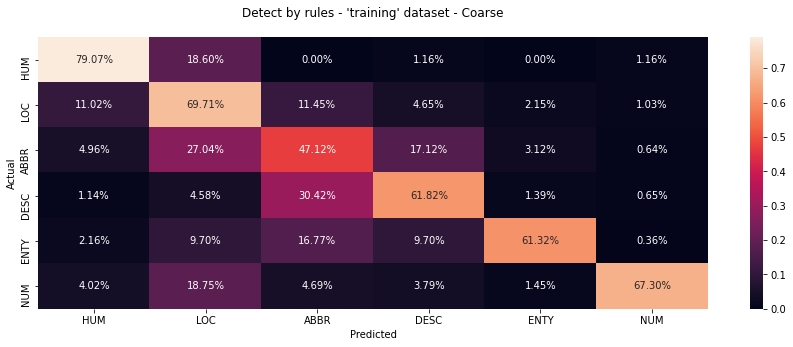

              precision    recall  f1-score   support

        ABBR       0.21      0.79      0.33        86
        DESC       0.55      0.70      0.62      1162
        ENTY       0.46      0.47      0.47      1250
         HUM       0.66      0.62      0.64      1223
         LOC       0.84      0.61      0.71       835
         NUM       0.95      0.67      0.79       896

    accuracy                           0.61      5452
   macro avg       0.61      0.64      0.59      5452
weighted avg       0.66      0.61      0.63      5452



In [332]:
import pandas as pd
import matplotlib.pyplot as plt

print(num_of_coarses)

base_cls = BaselineQuestionClassifier()
X = [l[2] for l in lines]
y_coarse = [l[0] for l in lines]
y_fine = [l[1] for l in lines]
y_pred = base_cls.predict(X)
evaluate_classifier(base_cls, X, y_coarse, "Detect by rules - 'training' dataset")

It actually not that bad! As expected `ENTY`, which we havn't found a strong rule to represent it by, is distributed over the 4 coarses, but even this challenging class has the highest match score in the right place - positive positive. `DESC`, which we were very genrous with and gave it all the case of "what" followed by "is" or "are" is taking some wrong answers as well. `ABBR` return the best results -  It seeme like simple rules can do imressive work, as long as there is clear differences between the categories we classify. We couldn't have done it with the fine classes, since there is no an easy-to-analyze border between sub categories of the coarses categories.
Time to check our test set:

In [333]:
numbers = []
testing_lines = []
for filename in findFiles('../data/TREC_10.label.txt'):
    testing_lines += readLines(filename)

X_test = [l[2] for l in testing_lines]
y_coarse_test = [l[0] for l in testing_lines]
y_fine_test = [l[1] for l in testing_lines]
y_pred_test = base_cls.predict(X_test)
print("Our test data looks like this:")
print(testing_lines[random.randint(0, len(testing_lines))])

Our test data looks like this:
['LOC', 'other', ['Where', 'is', 'the', 'Mason/Dixon', 'line']]


It's reporting time!


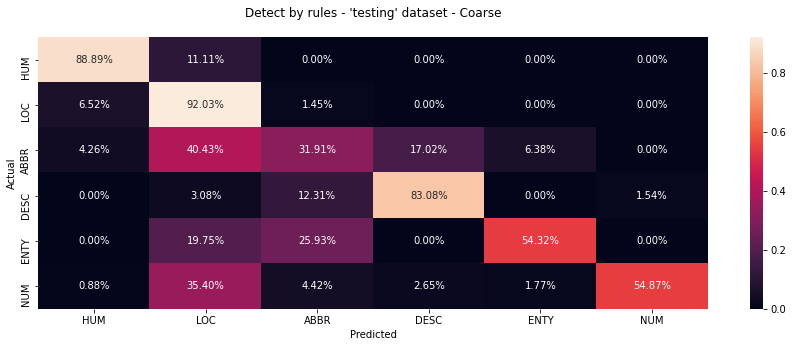

              precision    recall  f1-score   support

        ABBR       0.36      0.89      0.52         9
        DESC       0.57      0.92      0.70       138
        ENTY       0.45      0.32      0.38        94
         HUM       0.74      0.83      0.78        65
         LOC       0.85      0.54      0.66        81
         NUM       0.98      0.55      0.70       113

    accuracy                           0.65       500
   macro avg       0.66      0.68      0.62       500
weighted avg       0.70      0.65      0.64       500



In [334]:
evaluate_classifier(base_cls, X_test, y_coarse_test, "Detect by rules - 'testing' dataset")

The results in the testing set are quite similar. The rules can handle easily with `ABBR`, return good predictions for `LOC` and `NUM` and `HUM` thanks to their unique question word  "where", "how many/much/long", and "who"/"whom" respectively.
Let's talk in numbers:


The `precision` represents the amount of **true positive** out of sum of the true and false positive. `ABBR` score is 0.89 - it rarely makes a fakse positive decision thanks to the clear key word such as "abbrevation" or "acronym". `DESC` has the best score - we successfully recognize it and we don't make much mistakes. That's because we put it in the bottom of our rules, when most of the other classes was already classified. `ENTY` pay the price for being the default prediction with low score of 0.32 - thanks to lots of **false positive**.
`recall` can teach us how good are the rules in cathing positive cases. It returns the ratio of **true positive** to the sum of both **true positive** and and **false negative**. Here `NUM` leads with almost perfect score of 0.98. We can assume that it thanks to its rules - for example,  question starts with "how many" will probably be part of the `NUM` class, and not anything else. `ABBR` gets the lowest score, indicating a lot of **false negative** cases. 
A useful category is `f1-score`, holding the percent of **positive** predictions which were correct (F1 Score = 2*(Recall * Precision) / (Recall + Precision)).
`HUM` seems to have the best result with 0.78 since its precision and recall scorse are both above average. Its rules allows him to get this score - "who" and "whom" start a question that are looking for `PER`, and almost nothing else. On the other hand, the other rules dont "catch" the `PER`'s question.
So who cause the most errors? let's find out:


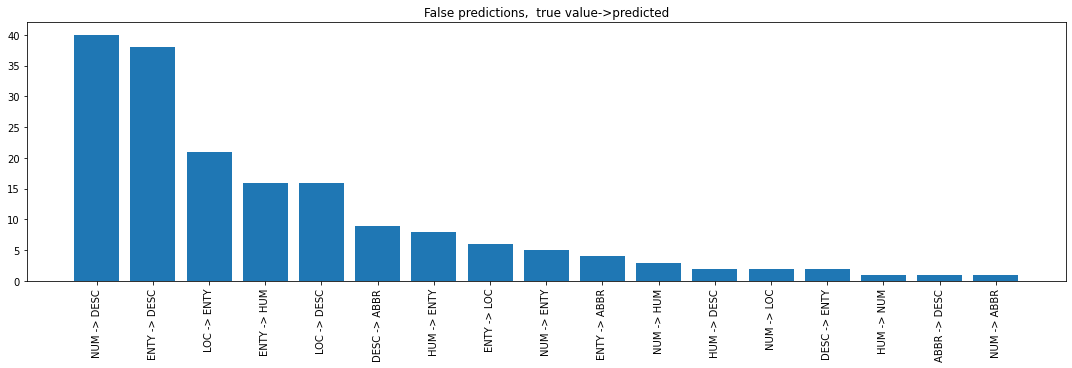

In [335]:
index = 0
missed_prediction = 0
o_ix_seq = 0
ix_iy_seq = 0
bx_iy_seq = 0
other = 0
missed_prediction_by_tag = []
prev_prediction = "FIRST"

for i, j in zip(y_coarse_test, y_pred_test):
    if i != j:
        missed_prediction += 1
        label = i+" -> "+j
        missed_prediction_by_tag.append(label)
    index += 1

tuples_of_labels = Counter(missed_prediction_by_tag).most_common(81)
word, frequency = zip(*tuples_of_labels)
indices = np.arange(len(tuples_of_labels))
plt.bar(indices, frequency)
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [15,5]
plt.title("False predictions,  true value->predicted")
plt.show()


Most of the error predictions are of type `NUM`->`DESC` and `ENTY`->`DESC`. In both cases the reason is probably the rule that classifies question that start with "what is" to `DESC`. While this rule causes troube, the default `ENTY' is not as bad as we could have expected, when `LOC` is the class who losses most question to `ENTY`.

<a name="q1.6"></a>
<h3>Q1.6 Features-based Classifier</h3>

Implement a feature-based classifier for the 6 coarse labels using the types of features described in the paper Section 3.2: words, POS tags, NER tags.  
<p/>

Use the <a href="https://spacy.io/usage/spacy-101">spacy</a> library to perform pre-processing of the questions - including POS tagging and Named Entity Recognition and Noun Chunks detection.  Spacy comes with excellent pre-trained models for English and other languages.
Installing Spacy requires the following steps (see <a href="https://spacy.io/usage/spacy-101#annotations-ner">spacy documentation</a>):


In [336]:
# This installs the Spacy library (13MB)
!pip install spacy
# This downloads pre-trained models for POS tagging / NER / Noun chunks in English (34MB)
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [337]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp('Apple is looking at buying U.K. startup for $1 billion')
print(doc.ents)
print(doc.ents[0].label_)

(Apple, U.K., $1 billion)
ORG


Invoking the 'nlp()' function of spacy performs a set of analyses on the text, including: sentence separation, tokenization, lemmatization, parts of speech tagging, 
Noun-phrase chunking, named entity recognition and syntactic parsing.  Information about these analyses is retrieved using the spacy document properties.

As indicated in the paper, we want to extract the following information as features for the task of question classification:
<ul>
  <li>Tokens</li>
  <li>Lemmas</li>
  <li>Parts of speech tags</li>
  <li>Noun phrase chunks</li>
  <li>Named entities</li>
</ul>

Here are starting points to learn how to extract this information from the nlp analysis:

In [338]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp('Apple is looking at buying U.K. startup for $1 billion')
  
# Token level features retrieved by Spacy: token, lemma, POS
for x in doc:   # Each x is a Token
    print(f"Token: {x} - Lemma: {x.lemma_} - POS: {x.pos_}")

Token: Apple - Lemma: Apple - POS: PROPN
Token: is - Lemma: be - POS: AUX
Token: looking - Lemma: look - POS: VERB
Token: at - Lemma: at - POS: ADP
Token: buying - Lemma: buy - POS: VERB
Token: U.K. - Lemma: U.K. - POS: PROPN
Token: startup - Lemma: startup - POS: NOUN
Token: for - Lemma: for - POS: ADP
Token: $ - Lemma: $ - POS: SYM
Token: 1 - Lemma: 1 - POS: NUM
Token: billion - Lemma: billion - POS: NUM


In [339]:
# Span level features retrieved by Spacy: named entities, start (0-based index), end (index just after the span), category
print(doc.ents)
for e in doc.ents: 
    print(f"{e} - {e.start} - {e.end} - {e.label_}")

(Apple, U.K., $1 billion)
Apple - 0 - 1 - ORG
U.K. - 5 - 6 - GPE
$1 billion - 8 - 11 - MONEY


In [366]:
# Span level features retrieved by Spacy: noun chunks
print(list(doc.noun_chunks))
for c in doc.noun_chunks: 
    print(f"{c.start} - {c.end} - {c.root}")
    print(str(doc[c.start:c.end]))


[Apple, U.K. startup]
0 - 1 - Apple
Apple
5 - 7 - startup
U.K. startup


The paper does not explicitly indicate how to encode the features it lists and is not precise about the features named `related words` (words which are usually associated with a specific type of questions).  For example:
<ol>
<li>Word features can be encoded in different ways: noise words filtered or not, with or without lemmatization, with or without case normalization (all lower-case).  
<li>POS features can be encoded in different ways: as a bag of POS-tags, or associated with the word in a bag-of-tagged words such as 'Apple/PROPN' 
<li>Chunks can be encoded as a bag of chunk-roots 
<li>Examples of "related words" per category are provided for a few categories: <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/lists/prof">profession</a>,
    <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/lists/mount">mountains</a> and <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/lists/food">food</a>.
  You should learn the related words list from the training dataset by detecting words which have a high chi-square
value with each category.  Read in <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html">sklearn.feature_selection.chi2</a> for a discussion of how such words can be efficiently computed using scikit-learn.
</li>
</ol>


<a name="q1.6.1"></a>
<h4>Q1.6.1 Feature Extraction</h4>

Discuss a priori what are good ways to encode these features (lemma, POS, NER, chunk, related words) - provide examples that explain your intuition.
<p/>
Implement a feature extraction function that turns a question into a feature vector appropriate for the scikit-learn classifiers.
Adopt the example shown in the scikit-learn documentation: 
<a href="https://scikit-learn.org/stable/modules/feature_extraction.html#loading-features-from-dicts">loading features from dicts</a>.

#### Lemma has many possible values, hence it make sense to encode it with a sparse matrix, with one-hot encoding for each lemma. In the context of question classification, it should proabably be case insensitive. For a question possibly taking the BoW, that is the sum of such vetcors may be he representation of the question. 
For example for the corpus: ["the apples are red", "the apple is green"] would be represented by a BoW of the lemmas: [the, apple, be, red, green] so (1,1,1,1,0) and (1,1,1,0,1) correspondingly.
#### POS has small number of possible values, hence it would make sense to encode n-grams of such POS, and perhaps have a tfidf of those n-gram for several n values. 
For example in the sentece 'Apple is looking at buying U.K. startup for $1 billion': each one of ['PROPN', 'AUX', 'VERB', 'ADP', 'VERB', 'PROPN', 'NOUN', 'ADP', 'SYM', 'NUM', 'NUM'] would add count of one, and should be normalzized by the log inverse of the document frequency in the corpus. same for bigrams: [['PROPN', 'AUX'], ['AUX', 'VERB'], ['VERB', 'ADP'], ['ADP', 'VERB'], ['VERB', 'PROPN'], ['PROPN', 'NOUN'], ['NOUN', 'ADP'], ['ADP', 'SYM'], ['SYM', 'NUM'], ['NUM', 'NUM']]
#### As in POs, for NER similarly, tf-idf could be used.
In the above example: ['ORG', 'GPE', 'MONEY']
#### Noun chunk may again be encoded as a parse matrix, by the word forms, and also possibly by their lemmas, or by the named entity replacement where possible.
For example 'U.K. startup' would add one to the feature 'GPE startup'. 
#### We may have a feature of related words from an outer source such as the provided example: <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/lists/prof">profession</a>, although there should definetly be better lists than that. We actually don't see a reason to explicity learn the related words feature from the training dataset. The Chi-Squrae is a feature selection method which can be used for all the above generated features, including the word form itself of course, and that will naturally be included in model without explicit features. 

In [359]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vecotrizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='uft8', ngram_range=(1, 2), stop_words = [])

In [360]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
lemma_vecotrizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='uft8', ngram_range=(1, 2), stop_words = [])
pos_vecotrizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='uft8', ngram_range=(1, 4), stop_words = [])
ner_vecotrizer = CountVectorizer(min_df=5, encoding='uft8', ngram_range=(1, 1), stop_words = [])
chunks_vecotrizer = TfidfVectorizer(min_df=5, encoding='uft8', ngram_range=(1, 1), stop_words = [])


<a name="q1.6.2"></a>
<h4>Q1.6.2 Train Models</h4>

Train scikit-learn based classifiers for:
<ol>
<li>Coarse labels
<li>All labels as a flat classifier
<li>A hierarchical classifier which predicts the fine-grained labels given the coarse label as proposed in the paper.  Implement this as a two-step procedure - run the coarse-label classifier, then a second level classifier which takes the prediction of the first classifier as input (one finer classifier per coarse category).
</ol>

For each of the three classifiers, report:
<ol>
<li>Accuracy, Precision, Recall, F-measure per label and confusion matrix.
<li>Provide examples of prediction errors (positive and negative).
<li>Discuss the most ambiguous label pairs (identified in the confusion matrix) and discuss whether the features you have used provide sufficient information to disambiguate the cases.
</ol>

You should experiment with different classifiers from those illustrated in the
<a href="https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html">
Classification of text documents using sparse features</a> example.
<p/>

/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


It's reporting time!


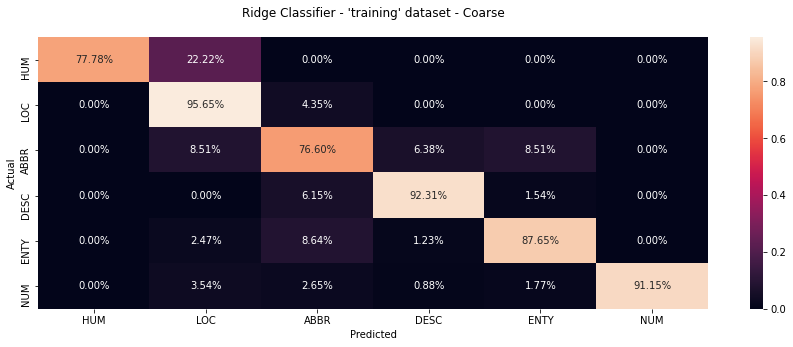

              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.89      0.96      0.92       138
        ENTY       0.78      0.77      0.77        94
         HUM       0.88      0.92      0.90        65
         LOC       0.87      0.88      0.87        81
         NUM       1.00      0.91      0.95       113

    accuracy                           0.89       500
   macro avg       0.90      0.87      0.88       500
weighted avg       0.89      0.89      0.89       500

It's reporting time!


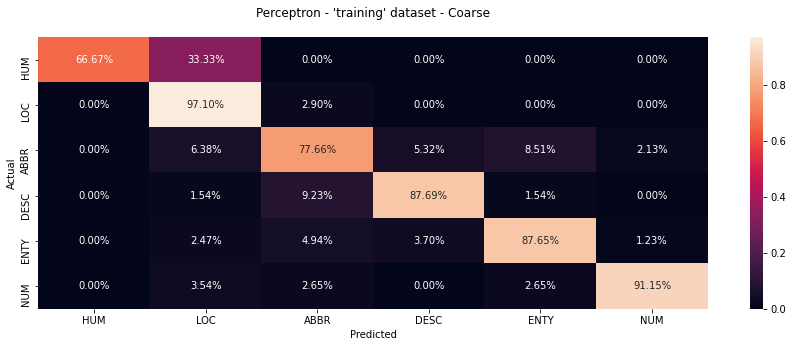

              precision    recall  f1-score   support

        ABBR       1.00      0.67      0.80         9
        DESC       0.89      0.97      0.93       138
        ENTY       0.81      0.78      0.79        94
         HUM       0.88      0.88      0.88        65
         LOC       0.86      0.88      0.87        81
         NUM       0.97      0.91      0.94       113

    accuracy                           0.89       500
   macro avg       0.90      0.85      0.87       500
weighted avg       0.89      0.89      0.89       500

It's reporting time!


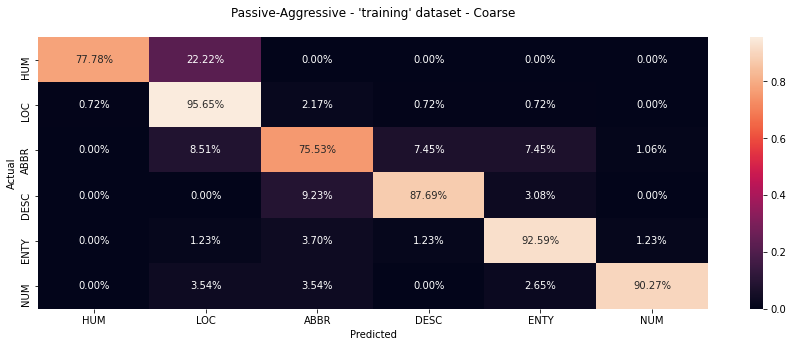

              precision    recall  f1-score   support

        ABBR       0.88      0.78      0.82         9
        DESC       0.90      0.96      0.93       138
        ENTY       0.82      0.76      0.78        94
         HUM       0.86      0.88      0.87        65
         LOC       0.85      0.93      0.89        81
         NUM       0.98      0.90      0.94       113

    accuracy                           0.89       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.89      0.89      0.89       500

It's reporting time!


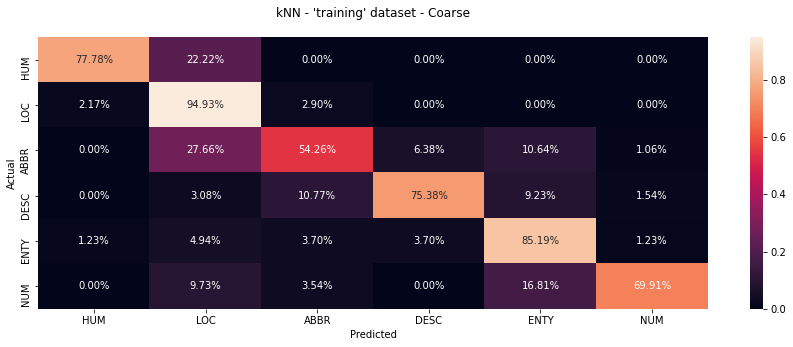

              precision    recall  f1-score   support

        ABBR       0.64      0.78      0.70         9
        DESC       0.74      0.95      0.83       138
        ENTY       0.74      0.54      0.63        94
         HUM       0.84      0.75      0.80        65
         LOC       0.66      0.85      0.75        81
         NUM       0.96      0.70      0.81       113

    accuracy                           0.77       500
   macro avg       0.77      0.76      0.75       500
weighted avg       0.79      0.77      0.77       500

It's reporting time!


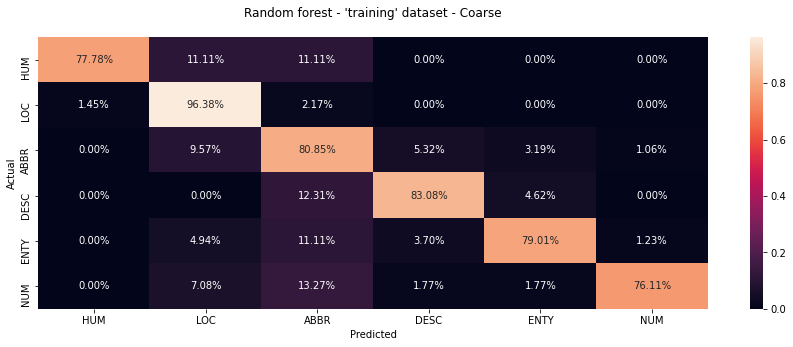

              precision    recall  f1-score   support

        ABBR       0.78      0.78      0.78         9
        DESC       0.86      0.96      0.91       138
        ENTY       0.68      0.81      0.74        94
         HUM       0.84      0.83      0.84        65
         LOC       0.89      0.79      0.84        81
         NUM       0.98      0.76      0.86       113

    accuracy                           0.84       500
   macro avg       0.84      0.82      0.83       500
weighted avg       0.85      0.84      0.84       500

It's reporting time!


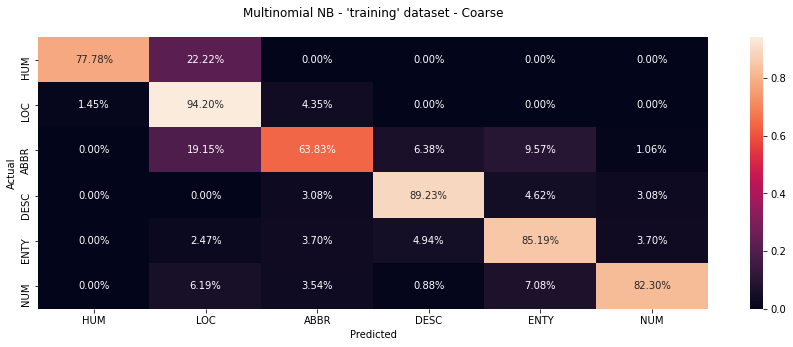

              precision    recall  f1-score   support

        ABBR       0.78      0.78      0.78         9
        DESC       0.82      0.94      0.88       138
        ENTY       0.80      0.64      0.71        94
         HUM       0.84      0.89      0.87        65
         LOC       0.78      0.85      0.81        81
         NUM       0.94      0.82      0.88       113

    accuracy                           0.83       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.84      0.83      0.83       500

It's reporting time!


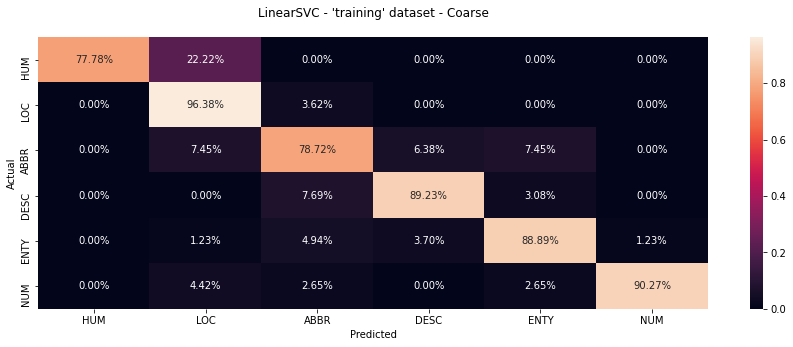

              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.90      0.96      0.93       138
        ENTY       0.81      0.79      0.80        94
         HUM       0.87      0.89      0.88        65
         LOC       0.86      0.89      0.87        81
         NUM       0.99      0.90      0.94       113

    accuracy                           0.89       500
   macro avg       0.90      0.87      0.88       500
weighted avg       0.89      0.89      0.89       500



/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


It's reporting time!


<ipython-input-329-a715352e3edc>:19: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mat = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]


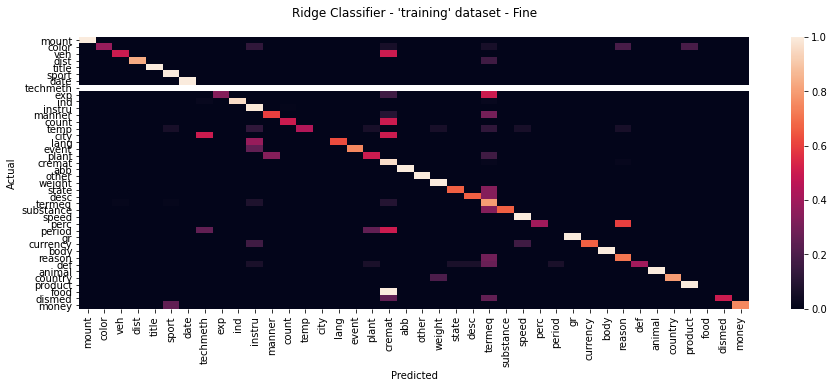

/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         abb       1.00      1.00      1.00         1
      animal       1.00      0.38      0.55        16
        body       0.50      0.50      0.50         2
        city       1.00      0.83      0.91        18
       color       1.00      1.00      1.00        10
       count       0.75      1.00      0.86         9
     country       1.00      1.00      1.00         3
      cremat       0.00      0.00      0.00         0
    currency       1.00      0.33      0.50         6
        date       1.00      0.96      0.98        47
         def       0.88      0.99      0.93       123
        desc       0.75      0.60      0.67        10
      dismed       0.50      0.50      0.50         2
        dist       1.00      0.44      0.61        16
       event       0.00      0.00      0.00         2
         exp       1.00      0.62      0.77         8
        food       1.00      0.75      0.86         4
          gr       0.50    

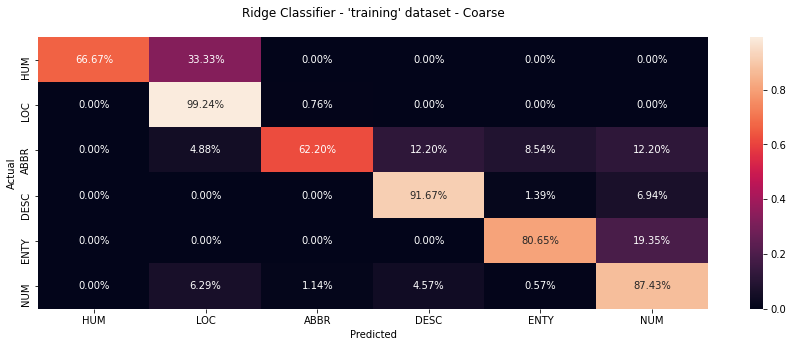

              precision    recall  f1-score   support

        ABBR       1.00      0.67      0.80         9
        DESC       0.88      0.99      0.93       131
        ENTY       0.94      0.62      0.75        82
         HUM       0.79      0.92      0.85        72
         LOC       0.74      0.81      0.77        31
         NUM       0.88      0.87      0.88       175

    accuracy                           0.86       500
   macro avg       0.87      0.81      0.83       500
weighted avg       0.87      0.86      0.86       500

It's reporting time!


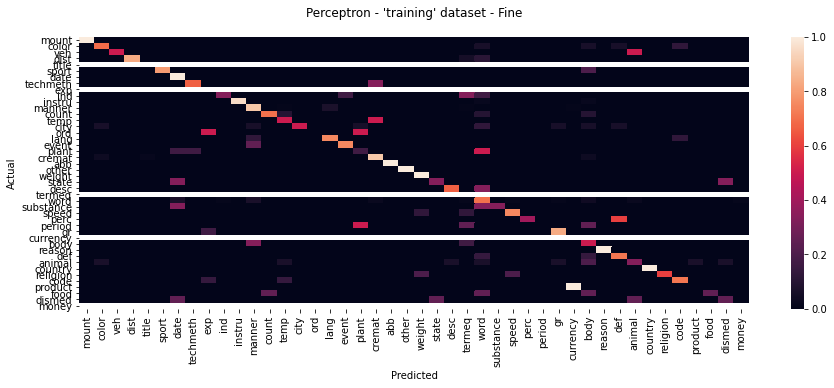

              precision    recall  f1-score   support

         abb       1.00      1.00      1.00         1
      animal       0.73      0.69      0.71        16
        body       1.00      0.50      0.67         2
        city       1.00      0.83      0.91        18
        code       0.00      0.00      0.00         0
       color       1.00      0.80      0.89        10
       count       0.50      1.00      0.67         9
     country       0.67      0.67      0.67         3
      cremat       0.00      0.00      0.00         0
    currency       0.67      0.33      0.44         6
        date       1.00      0.96      0.98        47
         def       0.92      0.90      0.91       123
        desc       0.88      0.70      0.78        10
      dismed       0.20      0.50      0.29         2
        dist       1.00      0.50      0.67        16
       event       0.00      0.00      0.00         2
         exp       0.40      0.75      0.52         8
        food       0.75    

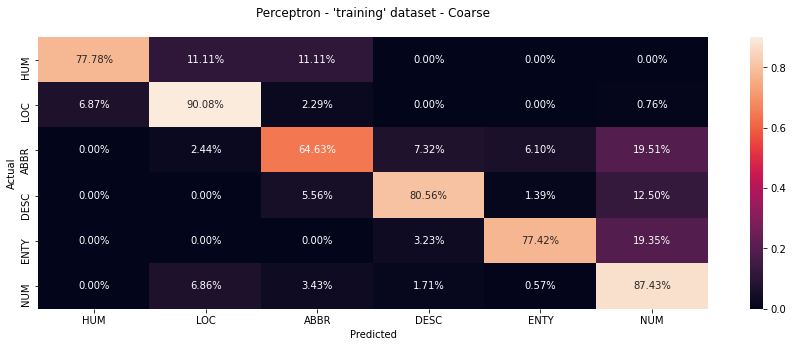

              precision    recall  f1-score   support

        ABBR       0.44      0.78      0.56         9
        DESC       0.89      0.90      0.89       131
        ENTY       0.79      0.65      0.71        82
         HUM       0.85      0.81      0.83        72
         LOC       0.77      0.77      0.77        31
         NUM       0.83      0.87      0.85       175

    accuracy                           0.83       500
   macro avg       0.76      0.80      0.77       500
weighted avg       0.83      0.83      0.83       500

It's reporting time!


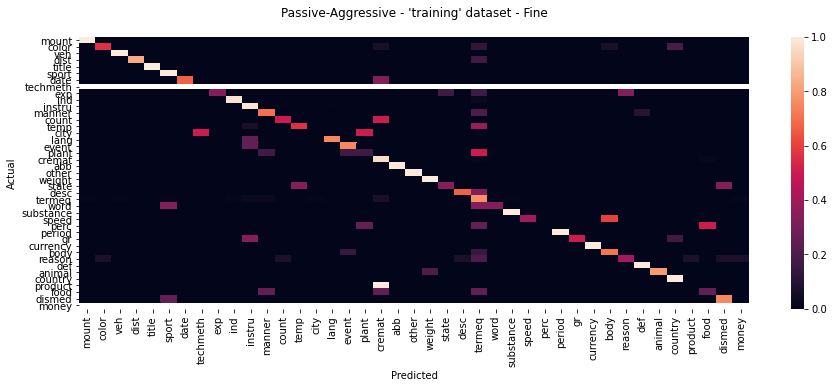

              precision    recall  f1-score   support

         abb       0.50      1.00      0.67         1
      animal       0.90      0.56      0.69        16
        body       0.67      1.00      0.80         2
        city       1.00      0.83      0.91        18
       color       1.00      1.00      1.00        10
       count       0.75      1.00      0.86         9
     country       1.00      0.67      0.80         3
      cremat       0.00      0.00      0.00         0
    currency       1.00      0.33      0.50         6
        date       0.98      0.98      0.98        47
         def       0.94      0.98      0.96       123
        desc       0.64      0.70      0.67        10
      dismed       0.33      0.50      0.40         2
        dist       0.90      0.56      0.69        16
       event       0.00      0.00      0.00         2
         exp       0.86      0.75      0.80         8
        food       0.60      0.75      0.67         4
          gr       0.33    

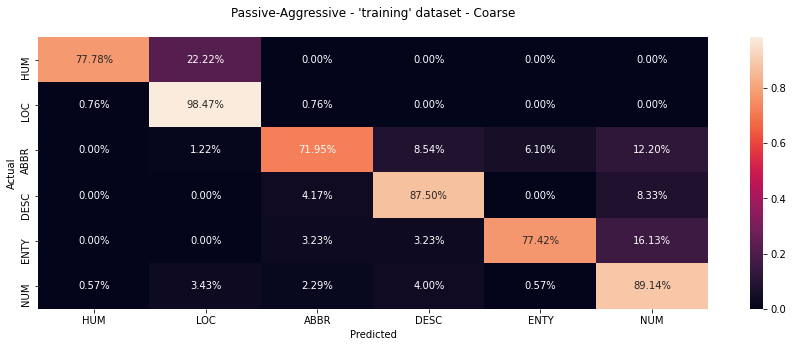

              precision    recall  f1-score   support

        ABBR       0.78      0.78      0.78         9
        DESC       0.93      0.98      0.96       131
        ENTY       0.87      0.72      0.79        82
         HUM       0.81      0.88      0.84        72
         LOC       0.80      0.77      0.79        31
         NUM       0.88      0.89      0.89       175

    accuracy                           0.88       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.88      0.88      0.87       500

It's reporting time!


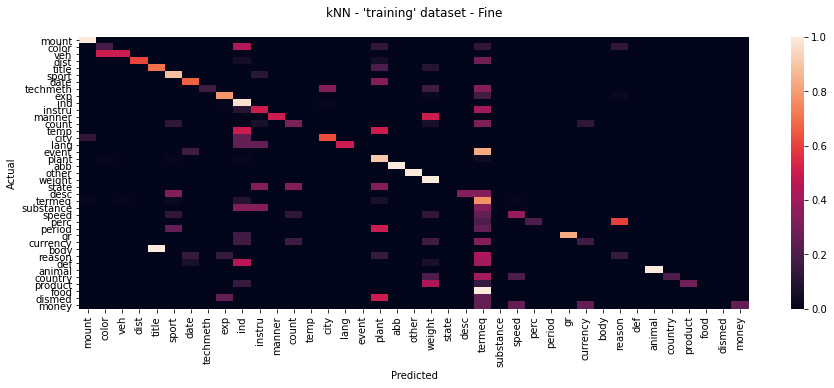

/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         abb       0.33      1.00      0.50         1
      animal       0.60      0.19      0.29        16
        body       0.50      0.50      0.50         2
        city       1.00      0.61      0.76        18
       color       0.88      0.70      0.78        10
       count       0.50      0.89      0.64         9
     country       0.40      0.67      0.50         3
    currency       1.00      0.17      0.29         6
        date       0.93      0.79      0.85        47
         def       0.79      0.98      0.87       123
        desc       0.50      0.50      0.50        10
      dismed       1.00      0.50      0.67         2
        dist       0.62      0.31      0.42        16
       event       0.00      0.00      0.00         2
         exp       0.56      0.62      0.59         8
        food       1.00      0.50      0.67         4
          gr       0.00      0.00      0.00         6
         ind       0.74    

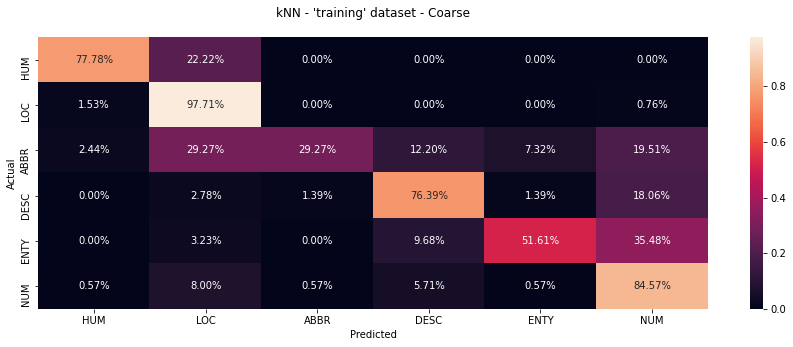

              precision    recall  f1-score   support

        ABBR       0.58      0.78      0.67         9
        DESC       0.75      0.98      0.85       131
        ENTY       0.92      0.29      0.44        82
         HUM       0.71      0.76      0.73        72
         LOC       0.67      0.52      0.58        31
         NUM       0.78      0.85      0.81       175

    accuracy                           0.76       500
   macro avg       0.73      0.70      0.68       500
weighted avg       0.77      0.76      0.73       500

It's reporting time!


<ipython-input-329-a715352e3edc>:19: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mat = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]


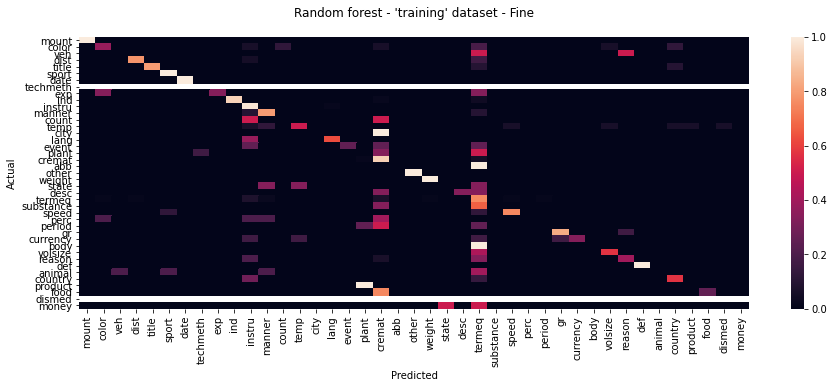

/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         abb       1.00      1.00      1.00         1
      animal       0.60      0.38      0.46        16
        body       0.00      0.00      0.00         2
        city       0.93      0.78      0.85        18
       color       1.00      0.80      0.89        10
       count       0.82      1.00      0.90         9
     country       1.00      1.00      1.00         3
      cremat       0.00      0.00      0.00         0
    currency       1.00      0.33      0.50         6
        date       1.00      0.94      0.97        47
         def       0.85      0.98      0.91       123
        desc       0.53      0.80      0.64        10
      dismed       0.00      0.00      0.00         2
        dist       0.80      0.50      0.62        16
       event       0.00      0.00      0.00         2
         exp       0.71      0.62      0.67         8
        food       1.00      0.25      0.40         4
          gr       0.00    

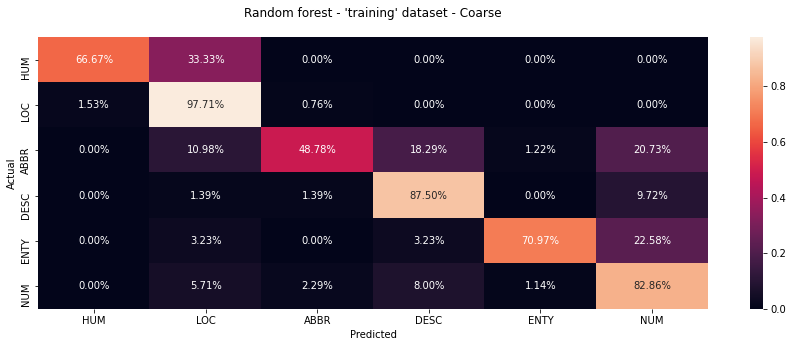

              precision    recall  f1-score   support

        ABBR       0.75      0.67      0.71         9
        DESC       0.84      0.98      0.90       131
        ENTY       0.87      0.49      0.62        82
         HUM       0.68      0.88      0.76        72
         LOC       0.88      0.71      0.79        31
         NUM       0.82      0.83      0.83       175

    accuracy                           0.81       500
   macro avg       0.81      0.76      0.77       500
weighted avg       0.82      0.81      0.80       500

It's reporting time!


<ipython-input-329-a715352e3edc>:19: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mat = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]


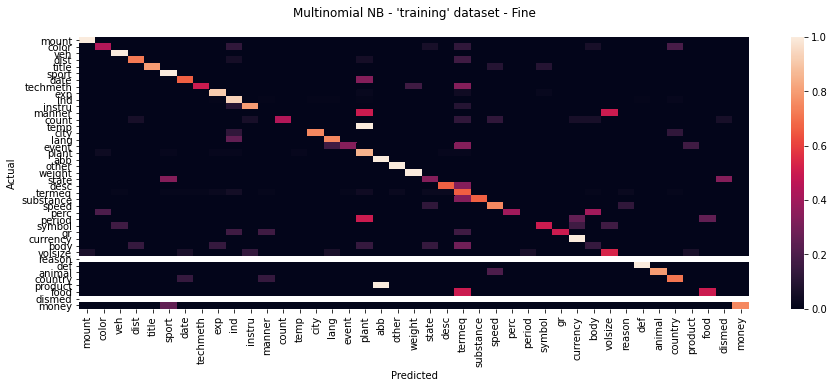

/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         abb       0.50      1.00      0.67         1
      animal       0.70      0.44      0.54        16
        body       0.50      1.00      0.67         2
        city       0.87      0.72      0.79        18
       color       1.00      0.80      0.89        10
       count       0.69      1.00      0.82         9
     country       0.40      0.67      0.50         3
    currency       0.75      0.50      0.60         6
        date       0.90      0.91      0.91        47
         def       0.91      0.93      0.92       123
        desc       0.73      0.80      0.76        10
      dismed       0.00      0.00      0.00         2
        dist       1.00      0.44      0.61        16
       event       0.00      0.00      0.00         2
         exp       0.86      0.75      0.80         8
        food       0.50      0.75      0.60         4
          gr       0.67      0.33      0.44         6
         ind       0.78    

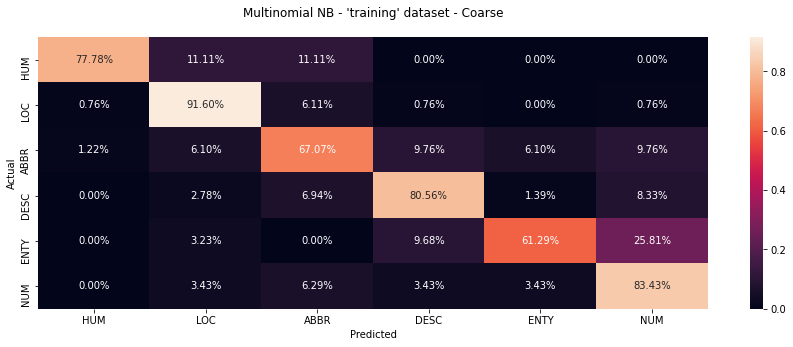

              precision    recall  f1-score   support

        ABBR       0.78      0.78      0.78         9
        DESC       0.89      0.92      0.90       131
        ENTY       0.69      0.67      0.68        82
         HUM       0.76      0.81      0.78        72
         LOC       0.61      0.61      0.61        31
         NUM       0.86      0.83      0.85       175

    accuracy                           0.81       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.81      0.81      0.81       500

It's reporting time!


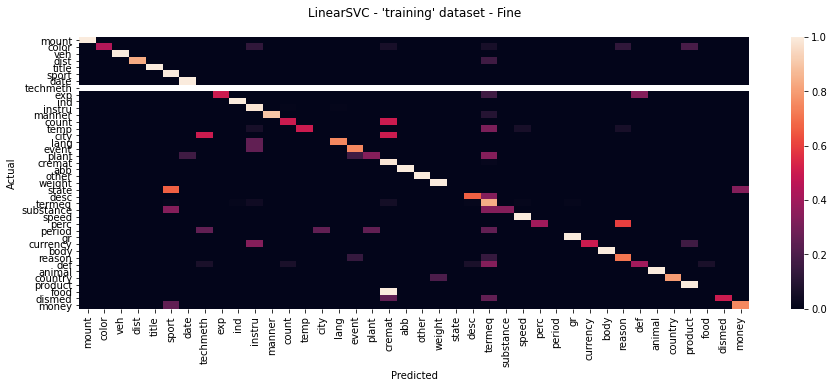

/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         abb       1.00      1.00      1.00         1
      animal       1.00      0.44      0.61        16
        body       1.00      1.00      1.00         2
        city       1.00      0.83      0.91        18
       color       1.00      1.00      1.00        10
       count       0.64      1.00      0.78         9
     country       0.75      1.00      0.86         3
      cremat       0.00      0.00      0.00         0
    currency       1.00      0.50      0.67         6
        date       0.98      1.00      0.99        47
         def       0.92      0.98      0.95       123
        desc       1.00      0.90      0.95        10
      dismed       0.33      0.50      0.40         2
        dist       1.00      0.50      0.67        16
       event       0.00      0.00      0.00         2
         exp       0.86      0.75      0.80         8
        food       0.60      0.75      0.67         4
          gr       0.67    

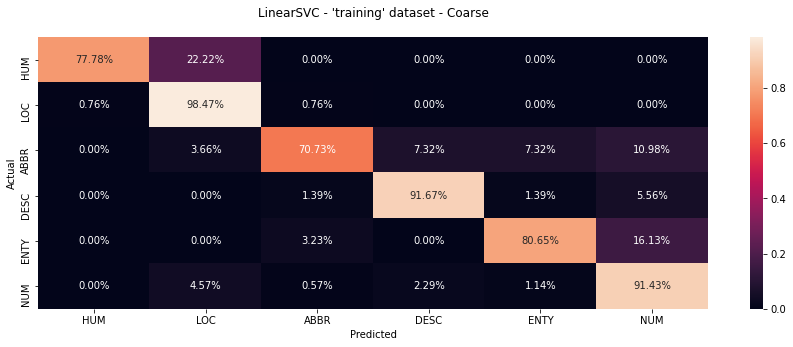

              precision    recall  f1-score   support

        ABBR       0.88      0.78      0.82         9
        DESC       0.91      0.98      0.95       131
        ENTY       0.94      0.71      0.81        82
         HUM       0.87      0.92      0.89        72
         LOC       0.74      0.81      0.77        31
         NUM       0.90      0.91      0.91       175

    accuracy                           0.89       500
   macro avg       0.87      0.85      0.86       500
weighted avg       0.89      0.89      0.89       500



In [389]:
import scipy as sp
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

# Of course it would be better to create a transformer for each one, and use FeatureUnion, but we will leave it for now...

nlps = [nlp(' '.join(x)) for x  in X]
X_lemma_train = lemma_vecotrizer.fit_transform([' '.join([y.lemma_ for y in x]) for x in nlps])
X_pos_train = pos_vecotrizer.fit_transform([' '.join([y.pos_ for y in x]) for x in nlps])
X_ner_train = ner_vecotrizer.fit_transform([' '.join([e.label_ for e in x.ents]) for x in nlps])
X_chunks_train = chunks_vecotrizer.fit_transform([' '.join(str(x[c.start:c.end]).replace(' ', '***') for c in x.noun_chunks) for x in nlps])
X_train = sp.sparse.hstack([X_lemma_train, X_pos_train, X_ner_train, X_chunks_train]).tocsr()

nlps_test = [nlp(' '.join(x)) for x  in X_test]
X_lemma_test = lemma_vecotrizer.transform([' '.join([y.lemma_ for y in x]) for x in nlps_test])
X_pos_test = pos_vecotrizer.transform([' '.join([y.pos_ for y in x]) for x in nlps_test])
X_ner_test = ner_vecotrizer.transform([' '.join([e.label_ for e in x.ents]) for x in nlps_test])
X_chunks_test = chunks_vecotrizer.transform([' '.join(str(x[c.start:c.end]).replace(' ', '***') for c in x.noun_chunks) for x in nlps_test])
X_test_str = sp.sparse.hstack([X_lemma_test, X_pos_test, X_ner_test, X_chunks_test]).tocsr()


# Feature selection did not improve results!

# ch2 = SelectKBest(chi2, k=3500)
# X_train = ch2.fit_transform(X_train, y_train)
# X_test_str = ch2.transform(X_test_str)

for y_train, y_test, is_fine in [(y_coarse, y_coarse_test, False), (y_fine, y_fine_test, True)]:
    for clf, name in (
            (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
            (Perceptron(max_iter=50), "Perceptron"),
            (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
            (KNeighborsClassifier(n_neighbors=10), "kNN"),
            (RandomForestClassifier(), "Random forest"),
            (MultinomialNB(alpha=.01), "Multinomial NB"),
            (LinearSVC(penalty='l2', dual=False, tol=1e-3), "LinearSVC")
    ):
        clf.fit(X_train, y_train)
        evaluate_classifier(clf, X_test_str, y_test, f"{name} - 'training' dataset", clf_is_fine=is_fine, y_is_fine=is_fine)

In [390]:
# class MultistepClassifier(BaseEstimator, ClassifierMixin):
#     def __init__(self, main_clf, value_to_clf):
#         self.main_clf = main_clf
#         self.value_to_clf = value_to_clf

#     def fit(self, X, y):
#         self.main_clf.fit(X, y[0])
#         for _ in 

#     def predict(self, X):
#         return [detect_type_by_text(q) for q in X]

class DummyClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, y):
        self.y = y

    def fit(self, X, y):
        pass

    def predict(self, X):
        return self.y

#### That's not a very efficient implementation, but it works... 
#### A better apporoch would be creating a MultistepClassifier and optimize it well (actually weird that's it's not part of the library...)
    

It's reporting time!


<ipython-input-329-a715352e3edc>:19: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mat = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]


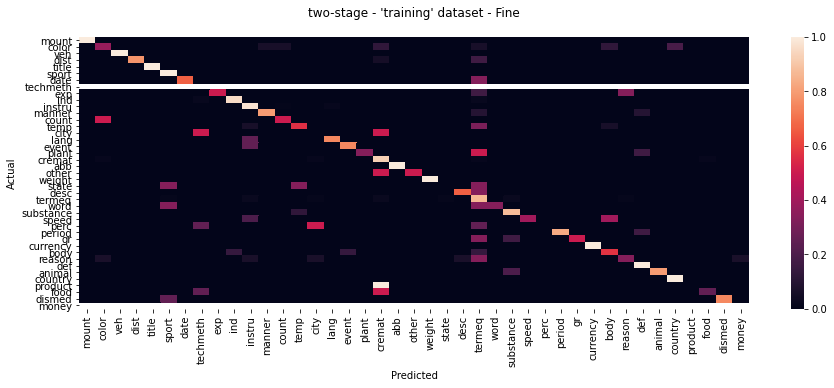

              precision    recall  f1-score   support

         abb       1.00      1.00      1.00         1
      animal       0.67      0.38      0.48        16
        body       1.00      1.00      1.00         2
        city       1.00      0.78      0.88        18
       color       1.00      1.00      1.00        10
       count       0.69      1.00      0.82         9
     country       1.00      0.67      0.80         3
      cremat       0.00      0.00      0.00         0
    currency       1.00      0.50      0.67         6
        date       0.98      0.96      0.97        47
         def       0.94      0.98      0.96       123
        desc       0.89      0.80      0.84        10
      dismed       0.33      0.50      0.40         2
        dist       0.82      0.56      0.67        16
       event       0.00      0.00      0.00         2
         exp       0.75      0.75      0.75         8
        food       0.75      0.75      0.75         4
          gr       1.00    

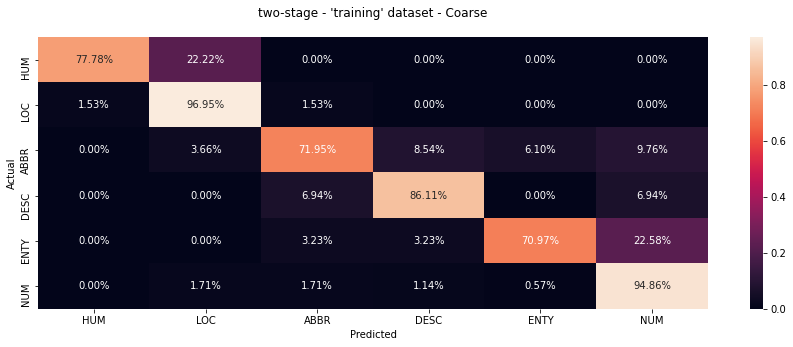

              precision    recall  f1-score   support

        ABBR       0.78      0.78      0.78         9
        DESC       0.94      0.97      0.95       131
        ENTY       0.84      0.72      0.78        82
         HUM       0.86      0.86      0.86        72
         LOC       0.79      0.71      0.75        31
         NUM       0.89      0.95      0.92       175

    accuracy                           0.89       500
   macro avg       0.85      0.83      0.84       500
weighted avg       0.88      0.89      0.88       500



In [392]:
clf_coarse = PassiveAggressiveClassifier(max_iter=50)
clf_coarse.fit(X_train, y_coarse)
clf_fines = {}
for y in set(y_coarse):
    i_s = []
    Y_fined = []
    for i, yy in enumerate(y_coarse):
        if yy==y:
            i_s.append(i)
            Y_fined.append(y_fine[i])
    X_fined = X_train[i_s, :]
#     XY = [(xx, yy_fine) for xx, yy_coarse, yy_fine in zip(X_train, y_coarse, y_fine) if yy_coarse == y]
    clf_fines[y] = LinearSVC(penalty='l2', dual=False, tol=1e-3)
#     X_fined = [x for x,y in XY]
#     Y_fined = [y for x,y in XY]
    clf_fines[y].fit(X_fined, Y_fined)
y_fine_test_pred = []
for i, yy in enumerate(y_test):
    X_test_str_i = X_test_str[i]
    yy_coarse_pred = clf_coarse.predict(X_test_str_i)
    yy_fine_pred = clf_fines[yy_coarse_pred[0]].predict(X_test_str_i)
    y_fine_test_pred.append(yy_fine_pred[0])
evaluate_classifier(DummyClassifier(y_fine_test_pred), X_test_str, y_fine_test, f"two-stage - 'training' dataset", clf_is_fine=True, y_is_fine=True)

#### The two-stage model performance was worse then the single stage model (at least using the best candidates from the first expirement).
#### Of course that much more thorrow search for the best combination is advised in real life (including each model's hyper parameters).

<a name="q1.7"></a>
<h3>Q1.7 Optional</h3>

1.7.1 Analyze which of the features are most helpful for this task among lemma, POS, NER, Chunks and Related Words.
(This analysis is called <a href="https://en.wikipedia.org/wiki/Ablation_(artificial_intelligence)#:~:text=In%20artificial%20intelligence%20(AI)%2C,component%20to%20the%20overall%20system.">ablation analysis</a>).
<p/>

1.7.2 The dataset is quite small (5,500 questions in the training dataset for 50 labels).
How would you determine whether your model overfits on this data? 

#### In principle We need to keep a validation set to get the performance of final model (there is no doubt we might have over-fitted the data with multiple candidate models).

<hr/>
<a name="q2"></a>
<h2>Q2. Document Classification</h2>

<a name="q2.1"></a>
<h3>Q2.1. Reuters Dataset</h3>

Execute the notebook tutorial of Scikit-Learn on text classification: 
<a href="http://scikit-learn.org/dev/auto_examples/applications/plot_out_of_core_classification.html#example-applications-plot-out-of-core-classification-py">out of core classification</a>.
<p/>

In [396]:
%matplotlib inline


# Out-of-core classification of text documents

This is an example showing how scikit-learn can be used for classification
using an out-of-core approach: learning from data that doesn't fit into main
memory. We make use of an online classifier, i.e., one that supports the
partial_fit method, that will be fed with batches of examples. To guarantee
that the features space remains the same over time we leverage a
HashingVectorizer that will project each example into the same feature space.
This is especially useful in the case of text classification where new
features (words) may appear in each batch.


In [397]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from html.parser import HTMLParser
from urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

## Reuters Dataset related routines

The dataset used in this example is Reuters-21578 as provided by the UCI ML
repository. It will be automatically downloaded and uncompressed on first
run.



In [398]:
class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        if _not_in_sphinx():
            sys.stdout.write('\r')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

## Main

Create the vectorizer and limit the number of features to a reasonable
maximum



In [399]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               alternate_sign=False)

DATA_PATH = "scikit_learn_data/reuters"
# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents(DATA_PATH)

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [('{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

Test set is 985 documents (132 positive)
                 SGD classifier : 	   865 train docs (   108 positive)    985 test docs (   132 positive) accuracy: 0.913 in 0.72s ( 1207 docs/s)
          Perceptron classifier : 	   865 train docs (   108 positive)    985 test docs (   132 positive) accuracy: 0.925 in 0.72s ( 1201 docs/s)
      NB Multinomial classifier : 	   865 train docs (   108 positive)    985 test docs (   132 positive) accuracy: 0.867 in 0.73s ( 1183 docs/s)
  Passive-Aggressive classifier : 	   865 train docs (   108 positive)    985 test docs (   132 positive) accuracy: 0.916 in 0.73s ( 1179 docs/s)


                 SGD classifier : 	  3798 train docs (   477 positive)    985 test docs (   132 positive) accuracy: 0.954 in 1.99s ( 1907 docs/s)
          Perceptron classifier : 	  3798 train docs (   477 positive)    985 test docs (   132 positive) accuracy: 0.951 in 1.99s ( 1903 docs/s)
      NB Multinomial classifier : 	  3798 train docs (   477 positive)    985 tes

## Plot results

The plot represents the learning curve of the classifier: the evolution
of classification accuracy over the course of the mini-batches. Accuracy is
measured on the first 1000 samples, held out as a validation set.

To limit the memory consumption, we queue examples up to a fixed amount
before feeding them to the learner.



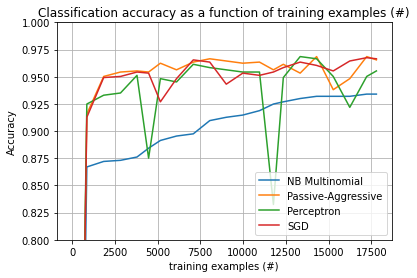

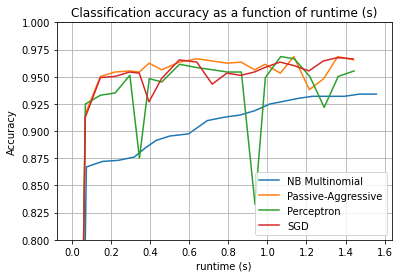

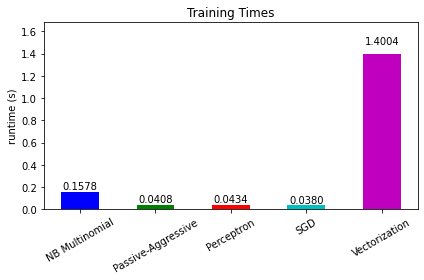

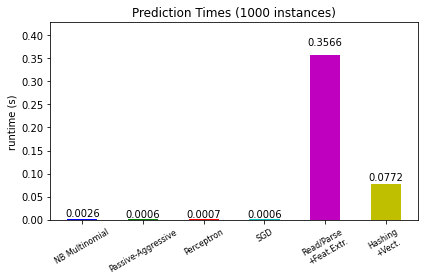

In [400]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)


rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats['total_fit_time']
               for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show()

<a name="q2.1.1"></a>
<h4>Q2.1.1 Descriptive Statistics</h4> 

Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. (use the pandas library to explore the dataset, use the dataframe.describe() method.)

Explore how many characters and words are present in the documents of the dataset.

In [401]:
import pandas as pd
from collections import Counter
cnt = Counter()
data_stream = stream_reuters_documents(DATA_PATH)
documents_cnt = 0
for i, doc in enumerate(data_stream):
    cnt.update(doc['topics'])
    documents_cnt += 1
df = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
df = df.rename(columns={'index':'category', 0:'count'})
print(f"There are {documents_cnt} documnets")
print(f"Documents per categories:")
print(df.describe())

There are 21578 documnets
Documents per categories:
              count
count    445.000000
mean      89.871910
std      644.656909
min        1.000000
25%        3.000000
50%        8.000000
75%       37.000000
max    12542.000000


In [402]:
def get_reuters_titles_bodies():
    titles = []
    bodies = []
    data_stream = stream_reuters_documents(DATA_PATH)
    for i, doc in enumerate(data_stream):
        titles.append(doc['title'].replace('<', '< ').replace('>', ' >'))
        bodies.append(doc['body'])
    return titles, bodies
titles, bodies = get_reuters_titles_bodies()


In [404]:
from itertools import chain
from nltk.tokenize import word_tokenize
title_word_counts = np.array([len(word_tokenize(s)) for s in titles])
bodies_word_counts = np.array([len(word_tokenize(s)) for s in bodies])
title_char_counts = np.array([len(s) for s in titles])
bodies_char_counts = np.array([len(s) for s in bodies])
concat = ' '.join(chain(titles, bodies))

In [406]:
from scipy import stats
print("token count for titles:")
print(stats.describe(title_word_counts))
print("token count for bodies:")
print(stats.describe(bodies_word_counts))
print("character count for titles:")
print(stats.describe(title_char_counts))
print("character count for bodies:")
print(stats.describe(bodies_char_counts))

print(f'There are {len(set(word_tokenize(concat)))} distinct words')
print(f'There are {len(set(concat))} distinct charachters')


token count for titles:
DescribeResult(nobs=21578, minmax=(0, 30), mean=8.115534340532024, variance=6.742595026604888, skewness=-0.19167955190533806, kurtosis=3.514971452916371)
token count for bodies:
DescribeResult(nobs=21578, minmax=(0, 1857), mean=132.2832978033182, variance=22848.9990823807, skewness=2.557167315913036, kurtosis=8.574938899417507)
character count for titles:
DescribeResult(nobs=21578, minmax=(0, 138), mean=44.53327463156919, variance=163.07172492999644, skewness=-0.3057915340310227, kurtosis=6.0164282861473986)
character count for bodies:
DescribeResult(nobs=21578, minmax=(0, 9875), mean=718.5276207248123, variance=671439.5956823492, skewness=2.53318985404983, kurtosis=8.477806480156351)
There are 91373 distinct words
There are 92 distinct charachters


<a name="q2.1.2"></a>
<h4>Q2.1.2 Partial-fit classifiers</h4> 

Explain informally what are the classifiers that support the "partial-fit" method discussed in the code.

#### SGDClassifier is a classifier that uses gradient decent to find the minimum lass of a linear model, possibly with regularization (which means using the gradient opposite direction to get closer to the local miminum, which for a linear function which is convex, will also be the global minimum).
#### Perceptron is an algorithm to find linear hyperplane to seperate two classes - it is similar to SVM, but does not try to maximize the distnace to that hyperplane, only to seperate the classes, and and it quicker, and more suited to online learning (or partial_fit as it is called in Scikit Learn).
#### MultinomialNB is a classifier that uses bayesian learning to learn a posterior for each class' probability. It is usually a smoothed version of MLE estimator (which is simple the relative frequency).
#### Passive-Aggressive classifier also finds hyperplane to seperate the classes. The difference is that it doesn't have a learning rate, and the weights are actually changed in a way that the last seen example always matches perfectly - this is the aggresive part. The apssive part is that it does nothing if the classifier is right for the last example.

<a name="q2.1.3"></a>
<h4>Q2.1.3 Hashing Vectorizer</h4> 

Explain what is the hashing vectorizer used in this tutorial.  Why is it important to use this vectorizer to achieve "streaming classification"?

#### HashingVectorizer use hashing to create sparse matrix, where each row represents one document. This property makes it stateless, because the conversion from word to index is not stored in memory. It also means the memory needed is relatively low. It does mean that a collision might occur if the number of different words is large enough.

#### The fact that there is no state makes it very suitable for streaming classification, since it means that the row may be computed online without corpus specific index for each word.

<a name="q2.2"></a>
<h3>Q2.2. BBC News Dataset</h3>

The <a href="https://www.kaggle.com/c/learn-ai-bbc/data">Kaggle BBC News</a> dataset is a document dataset to test document classification.
It contains 1,500 training documents (news stories from the BBC News) and 700 test documents. Documents are classified into 5 categories: sports, tech, business, 
entertainment, politics.  Text is encoded in the following format: all lower case, quotes are removed and separated, non period punctuations are removed.
For example:
<pre>
lifestyle  governs mobile choice  faster  better or funkier hardware alone is not going to help phone firms sell more handsets
research suggests.  instead  phone firms keen to get more out of their customers should not just be pushing the technology 
for its own sake. consumers are far more interested in how handsets fit in with their lifestyle than they are in screen size  
onboard memory or the chip inside  shows an in-depth study by handset maker ericsson.  
historically in the industry there has been too much focus on using technology   
said dr michael bjorn  senior advisor on mobile media at ericsson s consumer and enterprise lab.
</pre>

Download the data <a href="bbcnews.zip">bbcnews.zip</a> and place it in ../data.

<a name="q2.2.1"></a>
<h4>Q2.2.1 Dataset Exploration</h4>

Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. 

In [407]:
bbc_df = pd.read_csv('../data/BBC News Train.csv')

In [408]:
bbc_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [409]:
print(f"There are {len(bbc_df)} documents in the dataset")
categoies_df = bbc_df.groupby('Category')
categories_count = categoies_df['ArticleId'].count().reset_index(name='count').sort_values(['count'], ascending=False)
print("Articles by category:")
print(categories_count)
print("Aggregated stats:")
categories_count["count"].describe()

There are 1490 documents in the dataset
Articles by category:
        Category  count
3          sport    346
0       business    336
2       politics    274
1  entertainment    273
4           tech    261
Aggregated stats:


count      5.000000
mean     298.000000
std       39.742924
min      261.000000
25%      273.000000
50%      274.000000
75%      336.000000
max      346.000000
Name: count, dtype: float64

<a name="q2.2.2"></a>
<h4>Q2.2.2 Features Extraction</h4>

Select appropriate features for document classification and implement a scikit-learn vectorizer for this dataset.

In [410]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/en_core_web_sm -->
/home/amir/anaconda3/envs/NLP/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


### Since we have a very small corpus, simplifying the text sholuld generate much better results.
#### We've replaced the signs of currency by their word token (but to not have abiguity added currency to euro and pound.
#### We've also replaced also float numbers by a specific indicator, and the smae for int numbers.
#### Finally, we've used the lemma of each word instead of the original word to have more common words.
#### If the dataset was larger, perhaps it would have been better to keep the original words instead.

In [411]:
import re
import spacy
spacy.load('en')
from sklearn.feature_extraction.text import TfidfVectorizer
class MyLemmaVectorizer(TfidfVectorizer):
        
    # override analyzer
    def build_analyzer(self):
        
        currencies =  {
            '¥': 'yen',
            '$': 'dollar',
            '€': 'euro currency',
            '£': 'pound currency'
        }

        float_pattern = re.compile('([0-9]+\.[0-9])')
        int_pattern = re.compile('([0-9]+)')
        stop_words = self.get_stop_words()
        
        # create the analyzer that will be returned by this method
        def my_analyser(document):
            for key,val in currencies.items():
                document = document.replace(key, f' {val} ')
            document = float_pattern.sub(' floatindicator ',document)
            document = int_pattern.sub(' intindicator ',document)
            document = document.replace('.', '')
            
            lemmatizer = spacy.lang.en.English()
            tokens = lemmatizer(document)
            lemmatized_tokens = [token.lemma_ for token in tokens]
            
            # use CountVectorizer's _word_ngrams to generate n-grams given by user input
            return(self._word_ngrams(lemmatized_tokens, stop_words))
        return(my_analyser)
tfidf = MyLemmaVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='uft8', ngram_range=(1, 2), stop_words = [])
features = tfidf.fit_transform(bbc_df.iloc[:1000]['Text']).toarray()
features.shape

(1490, 24218)

In [412]:
[x for x in tfidf.get_feature_names() if 'floatindicator' in x]

['   floatindicator',
 '  floatindicator',
 '( floatindicator',
 'floatindicator',
 'floatindicator  ',
 'floatindicator   ',
 'floatindicator %',
 'floatindicator bn',
 'floatindicator m']

<a name="q2.2.3"></a>
<h4>Q2.2.3 Model Training and Evaluation</h4>

Implement a classifier for this dataset.  
<p/>
Report performance, confusion matrix and analyze errors.
<p/>

In order to run the test data, you will need to register to Kaggle and use their submission system.
To avoid the complexity of using the Kaggle submission system, split the train data into 80% training / 20% test.  
<p/>

You can see examples solving this task with good usage of scikit-learn APIs in <a href="https://www.kaggle.com/c/learn-ai-bbc/leaderboard">the Kaggle leaderboard</a>.
In particular, <a href="https://www.kaggle.com/aryankaul31/aryan-bbc-news-classification">aryan-bbc-news-classification</a> demonstrates data exploration for 
classification using pandas, tf-idf features, TSNE visualization for feature vectors, and chi-square correlation between features and labels. 

### The Kaggle notebook actually generates the features before splitting!!! 
### That means there is a data drift between train and test.

In [413]:
#### Converting categories into class id

In [414]:
bbc_df['category_id'] = bbc_df['Category'].factorize()[0]
category_id_df = bbc_df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [415]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

X_train, X_test, y_train, y_test = train_test_split(bbc_df['Text'], bbc_df['category_id'], test_size=0.20, random_state=42)
tfidf = MyLemmaVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='uft8', ngram_range=(1, 2), stop_words = 'english')
combined_features = FeatureUnion([("tfidf", tfidf), ("length", FunctionTransformer(func=lambda x: len(x)))])
model = MultinomialNB()
pipeline = Pipeline([('features', tfidf), ('model', model)])
pipeline.fit(X_train, y_train)



Pipeline(steps=[('features',
                 MyLemmaVectorizer(encoding='uft8', min_df=5,
                                   ngram_range=(1, 2), stop_words='english',
                                   sublinear_tf=True)),
                ('model', MultinomialNB())])

### Calculate accuracy

In [416]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.9865771812080537

### Show Confusion Matrix - Non Normalized

Text(0.5, 15.0, 'Predicted')

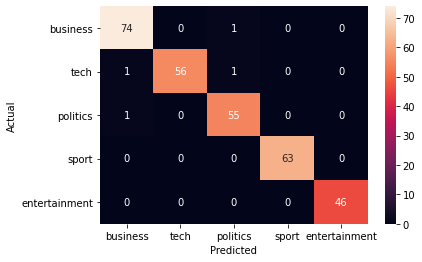

In [417]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Normalized confusion matrix - diagonal is all pink :-)

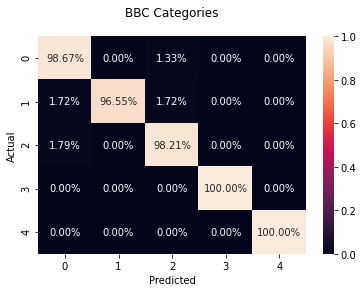

In [418]:
plot_confusion_matrix(y_test, y_pred, 'BBC Categories')

### On the test set, we only have 4 erros, so let's see all of them

In [419]:
for xx, yy, yy_pred in zip(X_test, y_test, y_pred):
    if yy!=yy_pred:
        print(f"Predicted '{id_to_category[yy_pred]}' instead of '{id_to_category[yy]}':")
        print(xx)
        print()
        

Predicted 'business' instead of 'tech':
pc ownership to  double by 2010  the number of personal computers worldwide is expected to double by 2010 to 1.3 billion machines  according to a report by analysts forrester research.  the growth will be driven by emerging markets such as china  russia and india  the report predicted. more than a third of all new pcs will be in these markets  with china adding 178 million new pcs by 2010  it said. low-priced computers made by local companies are expected to dominate in such territories  forrester said. the report comes less than a week after ibm  a pioneer of the pc business  sold its pc hardware division to china s number one computer maker lenovo.  the $1.75bn (£900m) deal will make the combined operation the third biggest pc vendor in the world.  today s products from western pc vendors won t dominate in those markets in the long term   simon yates  a senior analyst for forrester  said.  instead local pc makers like lenovo group in china and 

## We actually think that 3 of the 4 allegedly "errors" are True Positive! 
## The second example below should indeed be "tech".

<hr/>
<a name="q3"></a>
<h2>Q3. Named Entity Recognition</h2>

<h3>Named Entity Recognition</h3>

An important NLP task is NER. Recognizing name entities is an initial step of many other NLP tasks, and therefore a good NER is the key to great performances of other missions. We will be working on the CoNLL2002 [dataset](https://www.clips.uantwerpen.be/conll2002/ner/) from the [nltk.corpus](http://www.nltk.org/api/nltk.corpus.html).

Let's get our data! It is already saperated to 3 chunks of training, test a (testing), and test b (validation).

First, let's read the text we have as, well, a text. We will be working with texts in Spanish and Dutch - here are some sentences from our training dataset in bith language.

In [424]:
from termcolor import colored

from nltk.corpus import conll2002
etr_words_spanish = conll2002.words('esp.train')  # In Spanish
etr_words_dutch = conll2002.words('ned.train')  # In Dutch

print(colored("here are some sentences from the Spanish dataet:",attrs=['bold']))
i = 0
for word in etr_words_spanish[:113]:
    print(word, end=" ")
    if i % 15 == 0: print()
    i += 1
print("\n")
print(colored("here are some sentences from the Dutch dataet:",attrs=['bold']))
for word in etr_words_dutch[:98]:
    print(word, end=" ")
    if i % 15 == 0: print()
    i += 1


here are some sentences from the Spanish dataet:
Melbourne 
( Australia ) , 25 may ( EFE ) . - El Abogado General del 
Estado , Daryl Williams , subrayó hoy la necesidad de tomar medidas para proteger al 
sistema judicial australiano frente a una página de internet que imposibilita el cumplimiento de los 
principios básicos de la Ley . La petición del Abogado General tiene lugar después de 
que un juez del Tribunal Supremo del estado de Victoria ( Australia ) se viera 
forzado a disolver un jurado popular y suspender el proceso ante el argumento de la 
defensa de que las personas que lo componían podían haber obtenido información sobre el acusado 
a través de la página CrimeNet . 

here are some sentences from the Dutch dataet:
De tekst van het arrest is nog niet 
schriftelijk beschikbaar maar het bericht werd alvast bekendgemaakt door een communicatiebureau dat Floralux inhuurde . 
In '81 regulariseert de toenmalige Vlaamse regering de toestand met een BPA dat het bedrijf 
op eigen ko

Luckily, nltk allowing us to read our dataset when it's already parsed. The basic parsing looks like this:

In [425]:
etr_raw_spanish = conll2002.raw('esp.train')  # In Spanish
i = 0
for word in etr_raw_spanish[:113]:
    print(word, end="")


Melbourne NP B-LOC
( Fpa O
Australia NP B-LOC
) Fpt O
, Fc O
25 Z O
may NC O
( Fpa O
EFE NC B-ORG
) Fpt O
. Fp O


We will be using a more comfortable-to-work-with parsing. In this parsing each word (in this case "word" can be number, punctuation, url etc.) will be a tuple, built like this: `(<word>, <POS>, <NER>)`. This dataset contains only four entities - `LOC` for location, `PER` for person, `ORG` for organization and `MISC` for miscellaneous. Every word that doesn't belong to one of the mentioned category will be tagged with `O`. 


In [426]:
esp_train = conll2002.iob_sents('esp.train')  # In Spanish
dut_train = conll2002.iob_sents('ned.train')  # In Dutch
esp_testa = conll2002.iob_sents('esp.testa')  # In Spanish
dut_testa = conll2002.iob_sents('ned.testa')  # In Dutch
esp_testb = conll2002.iob_sents('esp.testb')  # In Spanish
dut_testb = conll2002.iob_sents('ned.testb')  # In Dutch
print("Spanish:")
i = 0
for word in esp_train[:1]:
    print(word, end="")
print("\n")
print("Dutch:")
i = 0
for word in dut_train[:1]:
    print(word, end="")

Spanish:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Dutch:
[('De', 'Art', 'O'), ('tekst', 'N', 'O'), ('van', 'Prep', 'O'), ('het', 'Art', 'O'), ('arrest', 'N', 'O'), ('is', 'V', 'O'), ('nog', 'Adv', 'O'), ('niet', 'Adv', 'O'), ('schriftelijk', 'Adj', 'O'), ('beschikbaar', 'Adj', 'O'), ('maar', 'Conj', 'O'), ('het', 'Art', 'O'), ('bericht', 'N', 'O'), ('werd', 'V', 'O'), ('alvast', 'Adv', 'O'), ('bekendgemaakt', 'V', 'O'), ('door', 'Prep', 'O'), ('een', 'Art', 'O'), ('communicatiebureau', 'N', 'O'), ('dat', 'Conj', 'O'), ('Floralux', 'N', 'B-ORG'), ('inhuurde', 'V', 'O'), ('.', 'Punc', 'O')]

It seems like there are a lot of `O` - not very surprising considiring the fact we look for name entities, and most of the words are just not entities.
let's understand the distribution of the tags in our data as it might help us better understand the results later:

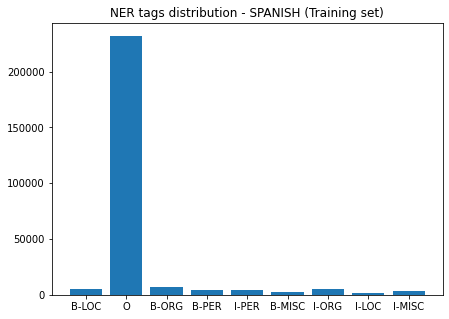

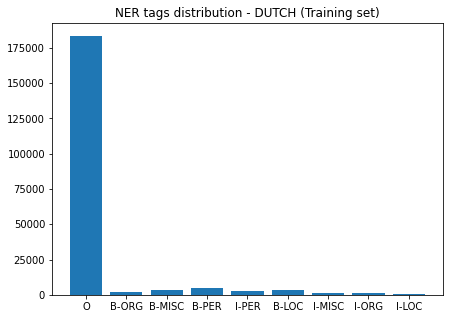

percent of 'O' in Spanish set
0.8761120450295601
percent of 'O' in Dutch set
0.9047689544225341


In [427]:
from collections import Counter
import matplotlib.pyplot as plt

def take_ner_tags (dataset):
    Y = []
    for sentence in dataset:
        for word in sentence:
            Y.append(word[2])
    return Y

esp_train_ner_tags = Counter(take_ner_tags(esp_train))
dut_train_ner_tags = Counter(take_ner_tags(dut_train))
esp_testa_ner_tags = Counter(take_ner_tags(esp_testa))
dut_testa_ner_tags = Counter(take_ner_tags(dut_testa))
esp_testb_ner_tags = Counter(take_ner_tags(esp_testb))
dut_testb_ner_tags = Counter(take_ner_tags(dut_testb))


labels, values = zip(*esp_train_ner_tags.items())
plt.rcParams['figure.figsize'] = [7,5]
plt.bar(labels, values)
plt.title("NER tags distribution - SPANISH (Training set)")
plt.show()

labels, values = zip(*dut_train_ner_tags.items())
plt.bar(labels, values)
plt.title("NER tags distribution - DUTCH (Training set)")
plt.show()
print("percent of 'O' in Spanish set")
print(esp_train_ner_tags['O']/sum(esp_train_ner_tags.values()))
print("percent of 'O' in Dutch set")
print(dut_train_ner_tags['O']/sum(dut_train_ner_tags.values()))


A lot of `O` indeed... We'll keep it mind and will see how it affects our learning.

<a name="q3.1"></a>
<h3>Q3.1 Features</h3>

It's time to look for some features that will help our model to do its mission. 

<a name="q3.1.1"></a>
<h4>Q3.1.1 Feature Extraction</h4>
We will start with collecting basic ORT features:

`number
contains_number
capitalized
all-capitalized
punctuation`

We will use Scikit-learn vectorizer and pipeline library for that.

First let's build our `word_to_feature`:

In [428]:
import re
def word_to_features(sentence, word_index):
    word_form = sentence[word_index][0]
    pos_tag = sentence[word_index][1]
    ner_yag = sentence[word_index][2]
    features = {
         'number': word_form.isdigit(),
         'contains_number': bool(re.search(r'\d', word_form)),
         'contains_hyphen': bool(re.search(r'-', word_form)), 
         'capitalized': word_form.istitle(),
         'all_capitalized': word_form.isupper(),
         'punctuation': (word_form in [".", ",", "(", ")", "\"", "\'", "?", "!", "-"])
    }
    return features


Now its time to prepare our training and testing data:

In [429]:
def prepare_x_y (dataset):
    print(".", end = "")
    X = []
    Y = []
    for sentence in dataset:
        index_in_sentence = 0
        for word in sentence:
            X.append(word_to_features(sentence, index_in_sentence))
            Y.append(word[2])
            index_in_sentence += 1
    return X, Y
    
print("preparing data", end = "")
X_esp_train, Y_esp_train = prepare_x_y(esp_train)
X_dut_train, Y_dut_train = prepare_x_y(dut_train)
X_esp_test_a, Y_esp_test_a = prepare_x_y(esp_testa)
X_dut_test_a, Y_dut_test_a = prepare_x_y(dut_testa)

print("\nour data is ready!")

preparing data....
our data is ready!


So how does our X_train look like? it's just a dictionary of `<feature>:<value>`. Right now all our features has boolean value so we don't need to worry about unseen features.
Let's print some words as features:

In [430]:
for feature in X_esp_train[:10]:
    print(feature)

{'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': True, 'all_capitalized': False, 'punctuation': False}
{'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': False, 'all_capitalized': False, 'punctuation': True}
{'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': True, 'all_capitalized': False, 'punctuation': False}
{'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': False, 'all_capitalized': False, 'punctuation': True}
{'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': False, 'all_capitalized': False, 'punctuation': True}
{'number': True, 'contains_number': True, 'contains_hyphen': False, 'capitalized': False, 'all_capitalized': False, 'punctuation': False}
{'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': False, 'all_capitalized': False, 'punctuation': False}
{'number': False, 'contains

So all we need to do now before we can start are actual training, is turn these features-dictionaries into vectors. luckily, scikit will help us doing so with `DictVectorizer`, which will [do](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) almost everything for us. We will use [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) as well - it will make our life easier and our code cleaner!

In [431]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

vec = DictVectorizer(sparse = True)

pip = Pipeline([
    ('vec', vec),
    ('clf', LogisticRegression(solver='newton-cg'))
])

<a name="q3.1.2"></a>
<h4>Q3.1.2 Model Training</h4>

Everything is ready - let's train our model and see what happens:


In [432]:
print("fitting Spanish dataset...")
pip.fit(X_esp_train, Y_esp_train)
predicted_esp = pip.predict(X_esp_test_a)
print(colored("Predicted NER tags for Spanish dataset:","red"))
print(predicted_esp[0:100])
print("fitting Dutch dataset...")
pip.fit(X_dut_train, Y_dut_train)
predicted_dut = pip.predict(X_dut_test_a)
print(colored("Real NER tags for Spanish dataset:","red"))
print(Y_esp_test_a[0:100])
print(colored("DONE!",attrs=['bold']))

fitting Spanish dataset...
Predicted NER tags for Spanish dataset:
['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-ORG' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
fitting Dutch dataset...
Real NER tags for Spanish dataset:
['B-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-LOC', 'I-LOC', 'O', 'O'

It seeme like our model missed most of the NER tags. It did cought the `B-ORG` in the 10th word, but missed many others. Let talk in numbers - 
First we will print some false prediction, to understand what its mistakes are (in Spanish):

In [433]:
index=0
missed_prediction = 0
for i,j in zip(Y_esp_test_a,predicted_esp):
    if i != j:
        missed_prediction += 1
        if missed_prediction%250==0: print("index:",index,"\ttrue value:",i, "predicted value:",j)
    index += 1

print(missed_prediction, "False predictions (SPANISH) were found, which are", round(missed_prediction/len(Y_esp_test_a)*100, 2), "% of the predictions")

print("SPANISH SCORE:", round(np.mean(predicted_esp == Y_esp_test_a),4))
print("DUTCH SCORE:", round(np.mean(predicted_dut == Y_dut_test_a),4))

index: 1966 	true value: I-MISC predicted value: O
index: 2988 	true value: I-MISC predicted value: O
index: 4693 	true value: B-ORG predicted value: O
index: 7528 	true value: I-MISC predicted value: O
index: 9419 	true value: I-PER predicted value: O
index: 11240 	true value: I-PER predicted value: O
index: 12512 	true value: B-ORG predicted value: O
index: 13942 	true value: B-PER predicted value: O
index: 15966 	true value: B-LOC predicted value: O
index: 17800 	true value: O predicted value: B-ORG
index: 19987 	true value: I-MISC predicted value: O
index: 21270 	true value: B-PER predicted value: O
index: 22683 	true value: B-ORG predicted value: O
index: 24561 	true value: I-ORG predicted value: O
index: 26949 	true value: B-LOC predicted value: O
index: 28449 	true value: I-ORG predicted value: O
index: 30351 	true value: I-ORG predicted value: O
index: 32758 	true value: I-ORG predicted value: O
index: 35331 	true value: I-ORG predicted value: O
index: 37011 	true value: I-ORG 

While the Spanish score might sounds like a good result we need to remember that model that returns `O` for every words returnspretty close result:

In [434]:
for i in range(0,len(predicted_esp)):
    predicted_esp[i] = 'O'
for i in range(0,len(predicted_dut)):
    predicted_dut[i] = 'O'
print("SPANISH SCORE:", round(np.mean(predicted_esp == Y_esp_test_a),4))
print("DUTCH SCORE:", round(np.mean(predicted_dut == Y_dut_test_a),4))

SPANISH SCORE: 0.857
DUTCH SCORE: 0.9015


So we want a better result of course. The key for that is more features - it will give the model more information to bases on when trying to predict the word's NER tag. Since our features are not onlt-booleans naw, we will help our model with unseen feature by recognizing these cases and tag them with `unseen`. Let's expand our features' function:

In [435]:
esp_etr_iob_sents_train = conll2002.iob_sents('esp.train')  # In Spanish
dut_etr_iob_sents_train = conll2002.iob_sents('ned.train')  # In Dutch
esp_etr_iob_sents_testa = conll2002.iob_sents('esp.testa')  # In Spanish
dut_etr_iob_sents_testa = conll2002.iob_sents('ned.testa')  # In Dutch
esp_etr_iob_sents_testb = conll2002.iob_sents('esp.testb')  # In Spanish
dut_etr_iob_sents_testb = conll2002.iob_sents('ned.testb')  # In Dutc
seen_features_words = []
seen_features_chars = []
seen_features_pos = []

def expended_word_to_features(sentence, word_index, is_training):
    word_form = sentence[word_index][0]
    pos_tag = sentence[word_index][1]
#     features = {'word_lower':"", 'pos_tag':"", 'prev_pos_tag':"",'next_pos_tag':"",
#                 'prefix1':"",'prefix2':"",'prefix3':"",'suffix1':"",'suffix2':"",'suffix3':"",
# #                 'first_word':"", 'last_word':"",
#                 'number':"",'contains_number':"", 'contains_hyphen':"",'capitalized':"",'all_capitalized':"",'punctuation':""}
#     features = {}
#     features['word_lower'] = word_form.lower() if is_training or (word_form.lower() in seen_features_words)  else "unseen_word"
#     features['pos_tag'] = sentence[word_index][1] if  is_training or sentence[word_index][1] in seen_features_pos else "unseen_pos"
#     if is_training  or sentence[word_index-1][1] in seen_features_pos:
#         features['prev_pos_tag'] = sentence[word_index-1][1] if word_index > 0 else 'BEGIN_POS_TAG'
#     else: features['prev_pos_tag'] = "unseen_pos"
#     if word_index < (len(sentence)-1):
#         if is_training or sentence[word_index+1][1] in seen_features_pos :
#             features['next_pos_tag'] = sentence[word_index+1][1]
#         else: features['next_pos_tag'] = "unseen_pos"
#     else: 'END_POS_TAG'
#     features['prefix1'] = word_form[:1] if is_training  or word_form[:1]  in seen_features_chars  else "unseen_char"
#     features['prefix2'] = word_form[:2] if is_training  or word_form[:2]  in seen_features_chars   else "unseen_char"
#     features['prefix3'] = word_form[:3] if is_training  or word_form[:3]  in seen_features_chars  else "unseen_char"
#     features['suffix1'] = word_form[-1:] if is_training or word_form[-1:] in  seen_features_chars  else "unseen_char"
#     features['suffix2'] = word_form[-2:] if is_training or word_form[-2:] in  seen_features_chars  else "unseen_char"
#     features['suffix3'] = word_form[-3:] if is_training or word_form[-3:] in  seen_features_chars  else "unseen_char"
#     features['number']:word_form.isdigit()
#     features['first_word']: word_index==0
#     features['last_word']: word_index==len(sentence)-1
#     features['contains_number'] = bool(re.search(r'\d', word_form))
#     features['contains_hyphen'] =  bool(re.search(r'-', word_form))
#     features['capitalized'] =  word_form.istitle()
#     features['all_capitalized'] = word_form.isupper()
#     features['punctuation'] = word_form in [".", ",", "(", ")", "\"", "\'", "?", "!", "-"]
    features = {
        'word_lower': word_form.lower(),
        'pos_tag': sentence[word_index][1],
        'prev_pos_tag': sentence[word_index-1][1] if word_index > 0 else 'BEGIN_POS_TAG',
        'next_pos_tag': sentence[word_index+1][1] if word_index < len(sentence) - 1 else 'END_POS_TAG',
        'first_word': word_index==0,
        'last_word': word_index==len(sentence)-1,
        'prefix1=': word_form[:1],
        'prefix2=': word_form[:2],
        'prefix3=': word_form[:3],
        'suffix1=': word_form[-1:],
        'suffix2=': word_form[-2:],
        'suffix3=': word_form[-3:],
        'length': len(word_form),
        'number': word_form.isdigit(),
        'contains_number': bool(re.search(r'\d', word_form)),
        'contains_hyphen':'-' in word_form,
        'capitalized': word_form.istitle(),
        'prev_capitalized': sentence[word_index-1][0].istitle() if word_index > 0 else False,
        'prev_capitalized': sentence[word_index+1][0].istitle() if word_index < len(sentence) - 1 else False,
        'all_capitalized': word_form.isupper(),
        'punctuation': (word_form in [".", ",", "(", ")", "\"", "\'", "?", "!", "-"])
        }
    return features


def expended_prepare_x_y (dataset, is_training):
    print(".", end = "")
    X = []
    Y = []
    for sentence in dataset:
        index_in_sentence = 0
        for word in sentence:
            X.append(expended_word_to_features(sentence, index_in_sentence, is_training))
            Y.append(word[2])
            index_in_sentence += 1
    return X, Y

print("preparing data", end = "")

X_esp_train, Y_esp_train = expended_prepare_x_y(esp_etr_iob_sents_train, True)
X_dut_train, Y_dut_train = expended_prepare_x_y(dut_etr_iob_sents_train, True)
# for features in X_esp_train:
#     features_list = features.values()
#     feature_index = 0
#     for feature in features_list:
#         if (feature not in [False,True]):
#             if feature_index == 0:
#                 if feature not in seen_features_words: seen_features_words.append(feature) 
#             if feature_index == 1:
#                 if feature not in seen_features_pos: seen_features_pos.append(feature)
#             else:
#                 if feature not in seen_features_chars: seen_features_chars.append(feature) 
#         feature_index += 1

X_esp_test_a, Y_esp_test_a = expended_prepare_x_y(esp_etr_iob_sents_testa, False)
X_dut_test_a, Y_dut_test_a = expended_prepare_x_y(dut_etr_iob_sents_testa, False)

X_esp_test_b, Y_esp_test_b = expended_prepare_x_y(esp_etr_iob_sents_testb, False)
X_dut_test_b, Y_dut_test_b = expended_prepare_x_y(dut_etr_iob_sents_testb, False)
print("\nour data is ready!")
print("SPANIH training set, as features:")
print(X_esp_test_a[0:1])
print("DUTCH training set, as features:")
print(X_dut_test_a[0:1])

preparing data......
our data is ready!
SPANIH training set, as features:
[{'word_lower': 'sao', 'pos_tag': 'NC', 'prev_pos_tag': 'BEGIN_POS_TAG', 'next_pos_tag': 'VMI', 'first_word': True, 'last_word': False, 'prefix1=': 'S', 'prefix2=': 'Sa', 'prefix3=': 'Sao', 'suffix1=': 'o', 'suffix2=': 'ao', 'suffix3=': 'Sao', 'length': 3, 'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': True, 'prev_capitalized': True, 'all_capitalized': False, 'punctuation': False}]
DUTCH training set, as features:
[{'word_lower': 'dat', 'pos_tag': 'Pron', 'prev_pos_tag': 'BEGIN_POS_TAG', 'next_pos_tag': 'V', 'first_word': True, 'last_word': False, 'prefix1=': 'D', 'prefix2=': 'Da', 'prefix3=': 'Dat', 'suffix1=': 't', 'suffix2=': 'at', 'suffix3=': 'Dat', 'length': 3, 'number': False, 'contains_number': False, 'contains_hyphen': False, 'capitalized': True, 'prev_capitalized': False, 'all_capitalized': False, 'punctuation': False}]


We will train our data again, with our new features, and see if there is any imrovement:

In [436]:
import time
start = time.process_time()
print("fitting Spanish dataset...")
pip.fit(X_esp_train, Y_esp_train)
print("finished in", (time.process_time() - start))
predicted_esp = pip.predict(X_esp_test_a)
start = time.process_time()
print("fitting Dutch dataset...")
pip.fit(X_dut_train, Y_dut_train) 
print("finished in", (time.process_time() - start))
print(colored("DONE!",attrs=['bold']))
predicted_dut = pip.predict(X_dut_test_a)
print("Lets see some false predictions from the Spanish testing:")
index=0
missed_prediction = 0
missed_prediction_by_tag = []
for i,j in zip(Y_esp_test_a,predicted_esp):
    if i != j:
        missed_prediction += 1
        label = i+" -> "+j
        missed_prediction_by_tag.append(label)
        if missed_prediction%250==0: print("index:",index,"\ttrue value:",i, "predicted value:",j)
    index += 1
print(missed_prediction, "False (Spanish) predictions were found, which are", round(missed_prediction/len(Y_esp_test_a)*100, 2), "% of the predictions")

print("Model prediction (Spanish):", round(np.mean(predicted_esp == Y_esp_test_a),4))
print("Model prediction (Dutch):", round(np.mean(predicted_dut == Y_dut_test_a),4))

fitting Spanish dataset...
finished in 330.0171634110002
fitting Dutch dataset...
finished in 192.22723683200002
DONE!
Lets see some false predictions from the Spanish testing:
index: 3575 	true value: I-ORG predicted value: O
index: 8785 	true value: I-ORG predicted value: O
index: 12822 	true value: I-MISC predicted value: O
index: 17602 	true value: B-LOC predicted value: B-ORG
index: 20819 	true value: I-ORG predicted value: B-MISC
index: 23757 	true value: B-ORG predicted value: I-PER
index: 28505 	true value: O predicted value: B-ORG
index: 32898 	true value: B-PER predicted value: I-PER
index: 37018 	true value: I-ORG predicted value: I-MISC
index: 40637 	true value: I-MISC predicted value: O
index: 43265 	true value: I-MISC predicted value: B-LOC
index: 47444 	true value: I-ORG predicted value: I-LOC
index: 52248 	true value: I-ORG predicted value: B-LOC
3300 False (Spanish) predictions were found, which are 6.24 % of the predictions
Model prediction (Spanish): 0.9376
Model pre

We improved our results - it seems like our model does a better job in tagging entities in Dutch. It seems like this language has more patterns that inflected in the different features, and help the model to recognize name entities. Again, it feels like most of the mistakes are when it predicts O instead of name entity - maybe because of the unbalanced number of O in the dataset.
An interesting fact we've noticed - the result are very close when we run the model on the full training set, and we run it on 1000 sentences. Perhaps the features are very specific and togethr with low number of labels the dataset's size has small influence on the learning. 
Let's see *where and how* it fails.

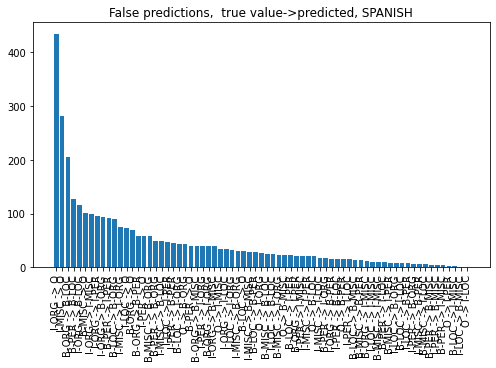

In [437]:
tuples_of_labels = Counter(missed_prediction_by_tag).most_common(81)
word, frequency = zip(*tuples_of_labels)
indices = np.arange(len(tuples_of_labels))
plt.bar(indices, frequency)
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20,5]
plt.title("False predictions,  true value->predicted, SPANISH")
plt.show()


As expected, most of the mistakes are when the model failed to detect entities, and classified them as `O`. Among the entities, it seems like it tends to classify entities as `B-MISC`, maybe since it can's decide exactly to what category they belong. Above that, we see an expected mistake of `I-PER`->`B-PER`, since it is has no "history" of its previous predictions. We will take care of it later.  

It is time to check our model on the the validation dataset!

In [438]:
start = time.process_time()
print("fitting Spanish dataset...")
pip.fit(X_esp_train, Y_esp_train)
print("finished in", (time.process_time() - start))
predicted_esp = pip.predict(X_esp_test_b)
start = time.process_time()
print("fitting Dutch dataset...")
pip.fit(X_dut_train, Y_dut_train) 
print("finished in", (time.process_time() - start))
print(colored("DONE!",attrs=['bold']))
predicted_dut = pip.predict(X_dut_test_b)
print("Model accuracy (Spanish):", round(np.mean(predicted_esp == Y_esp_test_b),4))
print("Model accuracy (Dutch):", round(np.mean(predicted_dut == Y_dut_test_b),4))

fitting Spanish dataset...
finished in 329.17828148399985
fitting Dutch dataset...
finished in 191.57257335899976
DONE!
Model accuracy (Spanish): 0.9512
Model accuracy (Dutch): 0.9711


It's a nice improvement than the first results. Let's dive in:

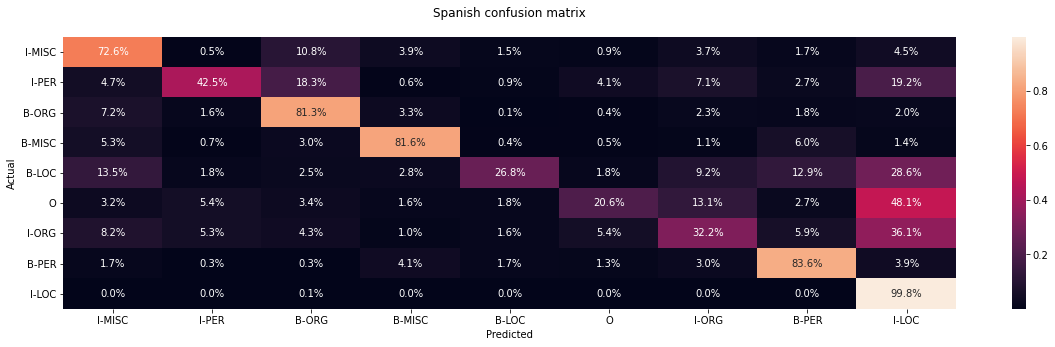

Scores reports - Spanish
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     46196
       B-ORG       0.81      0.79      0.80      1447
       I-ORG       0.32      0.60      0.42       595
       B-LOC       0.73      0.71      0.72      1114
       I-LOC       0.27      0.58      0.37       151
       B-PER       0.82      0.80      0.81       753
       I-PER       0.84      0.71      0.77       751
      B-MISC       0.42      0.49      0.46       293
      I-MISC       0.21      0.49      0.29       233

    accuracy                           0.95     51533
   macro avg       0.60      0.68      0.62     51533
weighted avg       0.97      0.95      0.96     51533



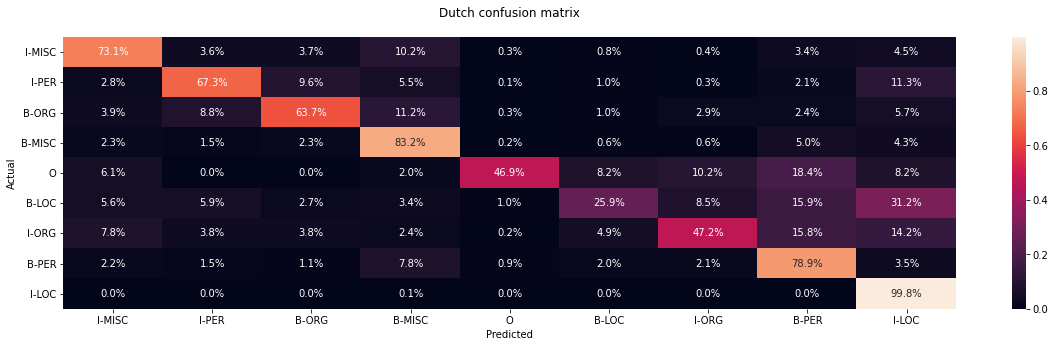

Scores reports - Dutch
              precision    recall  f1-score   support

           O       1.00      0.99      1.00     63521
       B-ORG       0.64      0.72      0.68       779
       I-ORG       0.47      0.71      0.57       365
       B-LOC       0.73      0.75      0.74       753
       I-LOC       0.47      0.52      0.49        44
       B-PER       0.83      0.71      0.77      1280
       I-PER       0.79      0.69      0.74       926
      B-MISC       0.67      0.79      0.73      1007
      I-MISC       0.26      0.53      0.35       200

    accuracy                           0.97     68875
   macro avg       0.65      0.71      0.67     68875
weighted avg       0.98      0.97      0.97     68875



In [439]:


from sklearn.metrics import classification_report as clsf_report

def report_results (X,Y,predicted,title):
    lang = title.split()[0]
    is_normalized = "Normalize" 
    classes_names = ['O','B-ORG','I-ORG','B-LOC','I-LOC','B-PER','I-PER','B-MISC','I-MISC']
    plot_confusion_matrix(Y,predicted, title, fmt='.1%')
    print(colored("Scores reports - "+lang,attrs=['bold']))
    print(clsf_report(predicted,Y,labels=classes_names))

report_results(X_esp_test_b,Y_esp_test_b,predicted_esp,"Spanish confusion matrix")
report_results(X_dut_test_b,Y_dut_test_b,predicted_dut,"Dutch confusion matrix")

By looking on the f1 score (a great explaination of the differences between the different scores is [here](https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397)) we can start to understand what is going on. It seeme like our model does a pretty good job in detevting `O` tags, with score of around 0.95 our of 1. It actually not very surprising - one of the first examination we had was that the majority (around 85%) of the tags are `O`, and therefore detectings `O`'s is not very challenging for our model. What about the other tags?
It seeme like the model does the best work with recognizing `PER` in Dutch, and its abilities in Spanish are not the best.

It's clear that our model do a better job with Dutch, when although the `O`, as always, is almost perfect, `PER` seems to bring pretty good prediction with 0.77 and 0.75. The Dutch prediction doesn't have many confusion of B-X I-X, while the Spanish one has a bit more of these.

<a name="q3.1.3"></a>
<h4>Q3.1.3 Greedy Tagging vs. Sequence Tagging</h4>

We implemented above a version of NER which is based on <i>greedy tagging</i>: that is, without optimizing the sequence of tags 
as we would obtain by training an HMM or CRF model.  
In particular, we did not check that the BIO tags produced by the tagger is a legal sequence.
Let's check how many times it happened, and how it affected our result:

SPANISH:
O_IX illegal sequence: 261 which are 10.37 % of missed prediction
IX_IY illegal sequence: 110 which are 4.37 % of missed prediction
BX_IY illegal sequence: 132 which are 5.24 % of missed prediction


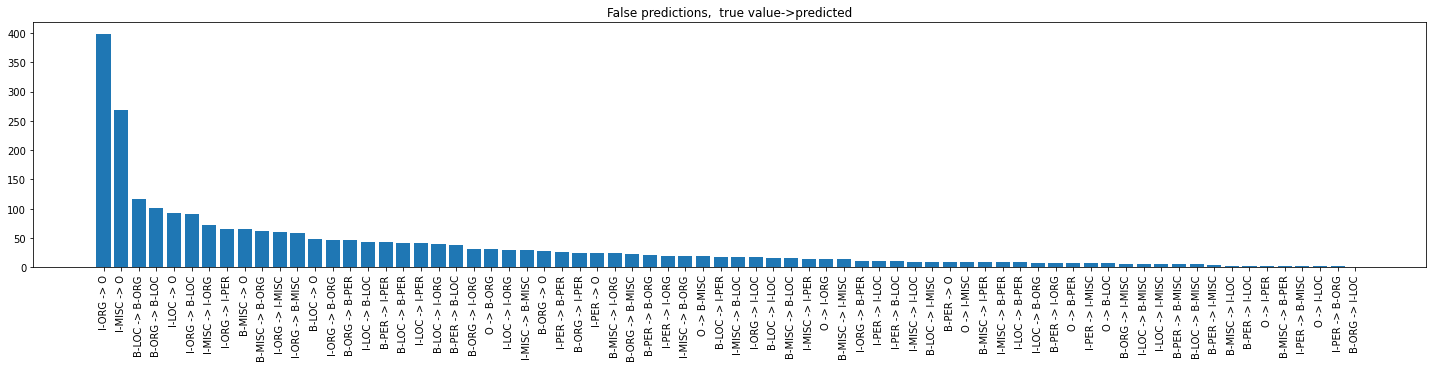

DUTCH:
O_IX illegal sequence: 110 which are 5.52 % of missed prediction
IX_IY illegal sequence: 73 which are 3.6700000000000004 % of missed prediction
BX_IY illegal sequence: 165 which are 8.290000000000001 % of missed prediction


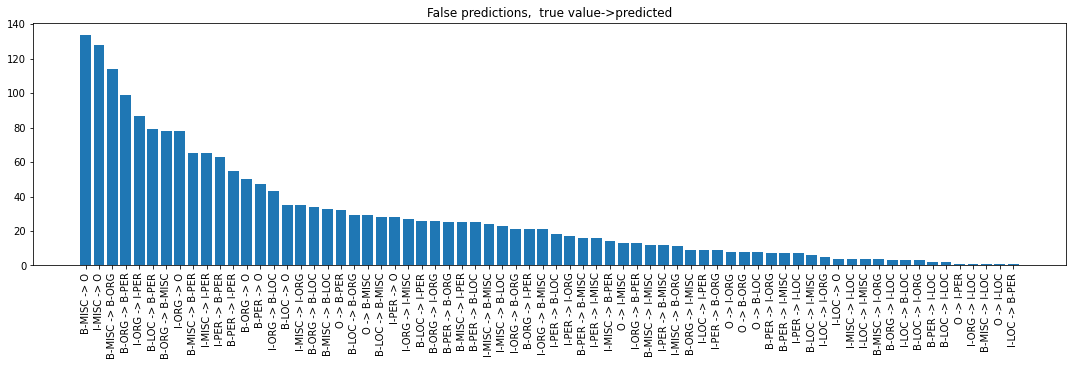

In [440]:
def is_o_ix(tag, prev_tag):
    return tag=='O' and prev_tag[0]=='I'

def is_ix_iy(tag, prev_tag):
    if tag[0]=='I' and prev_tag[0] == 'I':
        return tag[2:] != prev_tag[2:]
    else: False

def is_bx_iy(tag, prev_tag):
    if tag[0] == 'B' and prev_tag[0] == 'I':
        return tag[2:] != prev_tag[2:] 
    else: False
    
def check_illegal_sequence (Y_test, prediction, print_illegal_seq=True):
    index = 0
    missed_prediction = 0
    o_ix_seq = 0
    ix_iy_seq = 0
    bx_iy_seq = 0
    other = 0
    missed_prediction_by_tag = []
    prev_prediction = "FIRST"
    for i, j in zip(Y_test, prediction):
        if i != j:
            missed_prediction += 1
            label = i+" -> "+j
            missed_prediction_by_tag.append(label)
            if is_o_ix(j, prev_prediction): o_ix_seq += 1
            elif is_ix_iy(j, prev_prediction): ix_iy_seq += 1
            elif is_bx_iy(j, prev_prediction): bx_iy_seq += 1

            prev_prediction = j
        index += 1
    if print_illegal_seq:
        print("O_IX illegal sequence:", o_ix_seq, "which are", round(o_ix_seq/missed_prediction,4)*100,"% of missed prediction")
        print("IX_IY illegal sequence:",ix_iy_seq, "which are", round(ix_iy_seq/missed_prediction,4)*100,"% of missed prediction")
        print("BX_IY illegal sequence:",bx_iy_seq, "which are", round(bx_iy_seq/missed_prediction,4)*100,"% of missed prediction")
    
    tuples_of_labels = Counter(missed_prediction_by_tag).most_common(81)
    word, frequency = zip(*tuples_of_labels)
    indices = np.arange(len(tuples_of_labels))
    plt.bar(indices, frequency)
    plt.xticks(indices, word, rotation='vertical')
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [15,5]
    plt.title("False predictions,  true value->predicted")
    plt.show()

    
print("SPANISH:")
check_illegal_sequence(Y_esp_test_b, predicted_esp)
print("DUTCH:")
check_illegal_sequence(Y_dut_test_b, predicted_dut)

It seems that most of the illegal sequence our of type `BX_IY`, meaning it recognizes that the NER tag is not an `'O'`, it also recognizes it is not the first special entity in the sequence - but it's recognizing a wrong type. It failed to learn that after `BX` most come `IX` (if it's not an `'O'`).
We could have fixed it with a simple rule - but it wouldn't have imrove the results of the model as the major part of the mistakes envolove prediction of an `'O'` instead of a "special-entity", and not illegal sequences. 
As before - most of the mistakes are not of these type, but just confussion between different entities, mostly `O` to others or others to `O`.

<a name="q3.2"></a>
<h3>Q3.2 Using Word Embeddings</h3>

One way to improve a greedy tagger for NER is to use Word Embeddings as features.
A convenient package to manipulate Word2Vec word embeddings is provided in the <a href="https://radimrehurek.com/gensim/">gensim</a> package by Radim Rehurek.
To install it, use:

In [441]:
!pip install gensim

You must also download a pre-trained Word2Vec or fastText word embedding model.
The models must naturally be in Spanish or Dutch. (Only test word embeddings for one language.)
You can find pre-trained word embedding models in different formats:
<ol>
<li><a href="https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md">fastText pretrained models</a> (includes models for 294 languages)
<li><a href="https://github.com/uchile-nlp/spanish-word-embeddings">Spanish Word2vec models</a> 
</ol>

Specific information on manipulating word vectors with Gensim is provided in Gensim with the <a href="https://radimrehurek.com/gensim/models/keyedvectors.html">KeyedVector</a>.
Practical examples are available for Spanish in this <a href="https://github.com/uchile-nlp/spanish-word-embeddings/blob/master/examples/Ejemplo_WordVectors.ipynb">notebook</a>.
(Pay attention that word embeddings large are pretty big files - about 3GB when uncompressed.)

Your task:
<ol>
<li>Add word embeddings as dense vectors to the features of your NER classifier for each word feature (current word, previous word, next word) - either in Spanish or in Dutch.
<li>Retrain the model and report on performance.  Comment.
</ol>

#### Let's load a pretrained model and do sanity check
#### The pre-trained model was downloaded from:
http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.100k.vec.gz

In [442]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format('./pretrained/fasttext-sbwc.100k.vec')
# Sanity Check
print(word2vec.wv['adiós'])
print(vectors.most_similar(['adiós']))

2021-01-08 03:14:14,073 : loading projection weights from ./pretrained/fasttext-sbwc.100k.vec
2021-01-08 03:14:41,137 : loaded (100000, 300) matrix from ./pretrained/fasttext-sbwc.100k.vec


[-0.05674    -0.087737   -0.10786    -0.32012     0.21775     0.050855
 -0.1315     -0.016065   -0.0044382   0.12688     0.18585    -0.070083
 -0.28235    -0.10245    -0.20611     0.1017      0.33258    -0.359
 -0.11136     0.23638    -0.51962    -0.13206    -0.14344     0.33931
  0.03678    -0.51327     0.37875    -0.094703   -0.50939    -0.42146
 -0.29496     0.089489   -0.18215     0.26855     0.084926   -0.37135
 -0.17604     0.19987     0.34171    -0.02765     0.038043   -0.13986
 -0.060207   -0.019196    0.18761    -0.12706    -0.12553     0.19274
 -0.18154     0.015691    0.27281    -0.12293    -0.24932    -0.18562
 -0.22238     0.040998    0.33443    -0.42307     0.40378     0.13185
 -0.32028    -0.14587    -0.091597   -0.019445   -0.20897     0.076668
  0.26677     0.10073    -0.19205    -0.20759     0.20615    -0.14997
 -0.21445     0.32116     0.37717    -0.44479     0.15198    -0.41703
 -0.44199     0.064983    0.24149     0.00073189  0.16161     0.18455
 -0.039928    0.092

<ipython-input-442-ef8523622ca4>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print(word2vec.wv['adiós'])


fitting Spanish dataset...
finished in 1870.0655751000004
Model precision (Spanish): 0.9421


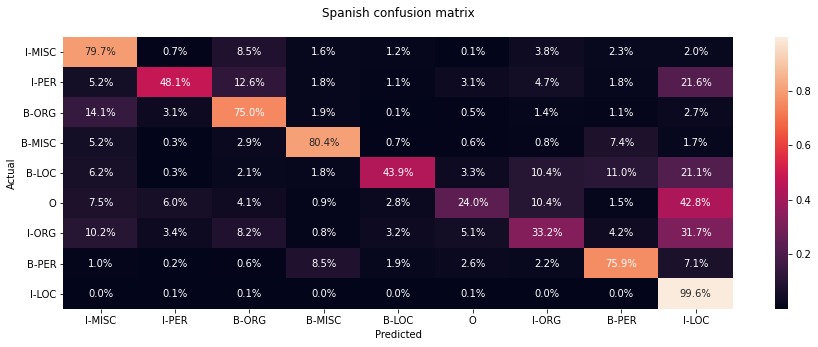

Scores reports - Spanish
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     46222
       B-ORG       0.75      0.78      0.76      1644
       I-ORG       0.33      0.66      0.44       690
       B-LOC       0.80      0.59      0.68      1337
       I-LOC       0.44      0.58      0.50       254
       B-PER       0.80      0.85      0.83      1153
       I-PER       0.76      0.73      0.74       898
      B-MISC       0.48      0.54      0.51       394
      I-MISC       0.24      0.47      0.32       331

    accuracy                           0.94     52923
   macro avg       0.62      0.69      0.64     52923
weighted avg       0.96      0.94      0.95     52923



In [456]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion

class Word2VecTransformer(TransformerMixin):
    def __init__(self,word2vec, **kwargs):
        self.word2vec = word2vec
        self.dim = len(word2vec.vectors[0])
        
    def fit(self, x, y=None):
        # Do nothing, already trained
        return self

    def transform(self, X):
        return np.array([
            self.word2vec[w['word_lower']] 
            if w['word_lower'] in self.word2vec
            else np.zeros(self.dim)
            for w in X
        ])

logistic_model = LogisticRegression(solver='newton-cg')
word_to_vec_model = Word2VecTransformer(word2vec)
pip_embedding = Pipeline([
    ('union', FeatureUnion([("word2vec", word_to_vec_model),
                            ('vec', vec)])),
    ('clf', logistic_model)
])

start = time.process_time()
print("fitting Spanish dataset...")
pip_embedding.fit(X_esp_train, Y_esp_train)
print("finished in", (time.process_time() - start))
predicted_esp_embedding = pip_embedding.predict(X_esp_test_a)
print("Model precision (Spanish):", round(np.mean(predicted_esp_embedding == Y_esp_test_a),4))
report_results(X_esp_test_a,Y_esp_test_a,predicted_esp_embedding,"Spanish confusion matrix")


Model precision (Spanish): 0.9543


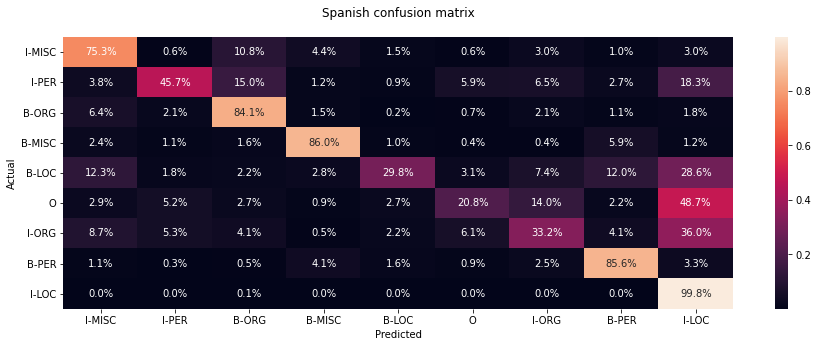

Scores reports - Spanish
              precision    recall  f1-score   support

           O       1.00      0.98      0.99     46185
       B-ORG       0.84      0.81      0.83      1450
       I-ORG       0.33      0.63      0.43       584
       B-LOC       0.75      0.74      0.75      1101
       I-LOC       0.30      0.54      0.39       178
       B-PER       0.86      0.84      0.85       754
       I-PER       0.86      0.75      0.80       724
      B-MISC       0.46      0.50      0.48       311
      I-MISC       0.21      0.47      0.29       246

    accuracy                           0.95     51533
   macro avg       0.62      0.70      0.64     51533
weighted avg       0.97      0.95      0.96     51533

O_IX illegal sequence: 258 which are 10.95 % of missed prediction
IX_IY illegal sequence: 98 which are 4.16 % of missed prediction
BX_IY illegal sequence: 116 which are 4.92 % of missed prediction


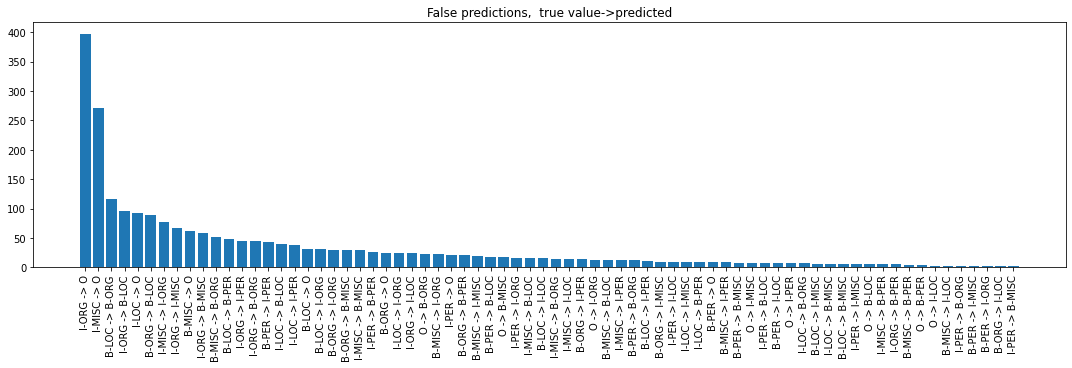

In [455]:
predicted_esp_embedding = pip_embedding.predict(X_esp_test_b)
print("Model precision (Spanish):", round(np.mean(predicted_esp_embedding == Y_esp_test_b),4))
report_results(X_esp_test_b,Y_esp_test_b,predicted_esp_embeddind,"Spanish confusion matrix")
check_illegal_sequence(Y_esp_test_b, predicted_esp_embedding)

#### We got better resutls (precision of 0.9543), it looks like the pre-trained embedding have added more information to correctly classify the NER
#### The errors are still very similar, 
#### There are many improvemnets that could be done to the model:
1. The embedding of non-adjuacents words that are dependent of that word in the parsing tree could be used.
2. Feature selection is also a very important tool to remove noisy features from the model.
3. We used a relatively small pre-trined embedding - using a bigger model would cover more words, and possibly have better performance as well. 
